## Cargamos los imports.

In [1]:
import init
import warnings
warnings.filterwarnings('ignore')

In [2]:
import grafo 
import experimento as exp
from experimento import plot_inflaciones, verEvolucion
import modelo 
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import quantecon_book_networks
import quantecon_book_networks.input_output as qbn_io
import quantecon_book_networks.plotting as qbn_plt
import quantecon_book_networks.data as qbn_data

## Estudio de la propagación y dinámica de precios a partir de la Matriz de Insumo-Producto (MIP)

**Grupo**: 6

**Integrantes**: Miguel De Lillo, Manuel Fernandez, Augusto Kielbowicz, Mariano Oca 

[**Repositorio**](https://github.com/akielbowicz/tp-msscae-2024?tab=readme-ov-file#trabajo-pr%C3%A1ctico-de-msscae-2024)

# Motivación
La idea de este modelo es estudiar, ante un shock de precios en un sector dado, cómo afectan las dinámicas propuestas entre los sectores productivos de la Argentina en la inflación global calculada a partir de las variaciones en los precios de los mismos. (Utilizando las relaciones dadas por la matriz de Insumo-Producto). 


<!-- Ejemplo de los resultados del grafo de MIP y la curva de inflacion -->
TODO: Agregar imagenes acá
<!-- ![grafo](./grafo.png) -->

<!-- ![inflacion](./inflacion.png) -->

<!-- Indice/TOC -->
- [Introducción](#Introducción)
    - [Preguntas a responder](#Preguntas-a-responder)
    - [Suposiciones (y limitaciones) del modelo](#Suposiciones-(y-limitaciones)-del-modelo)
- A
- B
- C
- [Conclusiones](#Conclusiones)
- [Apéndices](#Apéndices)
    - [Código](#Código) 

# Introducción

## Preguntas a Responder

- ¿Cómo se propaga el aumento de precios a través de la red definida por la MIP?

- ¿Cómo impacta el aumento de precio en un producto/sector sobre otros productos/sectores? ¿Se mantiene en la misma cadena productiva?

- ¿Cómo influyen la dinámica de comportamiento de los agentes en la variación de la inflación global?

- ¿Cuál es la sensibilidad del sistema respecto a variaciones de precio en nodos específicos? ¿Cuáles son los nodos que propagan de mayor forma la variación de precios?

## Descripción del Modelo

- Cada sector productivo de la Argentina es representado por un nodo del digrafo. El mismo representaría a todos los productos (y productores) del sector.

- Cada arista del digrafo representa la relación "le vende a" donde el peso de la arista es el porcentaje de la producción total que es comparada.

- Tanto los sectores productivos como los pesos que le corresponden a cada arista son extraídos de la Matriz Inzumo Producto del 1997 publicada por el INDEC. Los valores de dicha matriz son normalizados para que representen porcentajes, afines a la experimentación que se quiere realizar sobre el modelo.

## Suposiciones (y limitaciones) del Modelo

- Un cambio de precios >0 en los insumos provoca un cambio de precios saliente del agente (producción). Sólo vamos a estudiar variaciones positivas en los precios para atenernos a las preguntas a investigar con el modelo.

- La economía es cerrada. Esto es, no se traen productos de otros países (importaciones) ni se vende nada a ellos (exportaciones) durante la evolución del sistema.

- Rige la Ley de Say: la oferta es igual a la demanda.

# Matriz Insumo Producto, Grafo y Análisis

Cargamos la matriz insumo producto normalizada por demanda saliente.

In [3]:
mip = pd.read_csv('../resources/MIP_normalizada.csv', index_col=0)
mip.shape

(123, 123)

In [4]:
mip.head()

,"Cultivo de cereales, oleaginosas y forrajeras","Cultivo de hortalizas, legumbres, flores y plantas ornamentales",Cultivo de frutas y nueces,Cultivos industriales,Producción de semillas,"Cría de ganado y producción de leche, lana y pelos",Producción de granja,Servicios agropecuarios,Caza,Silvicultura y extracción de madera,...,Enseñanza pública,Enseñanza privada,Salud humana pública,Salud humana privada,Servicios veterinarios,Servicios sociales,Servicios de saneamiento,Actividad de asociaciones,"Servicios de cine, radio y televisión","Servicios personales, de reparación, actividades deportivas y de esparcimiento"
"Cultivo de cereales, oleaginosas y forrajeras",0.010319,0.000000,0.001542,0.001601,0.00000,0.181660,0.012263,0.0,0.0,0.0,...,0.000038,0.000080,0.000007,0.000042,0.000012,0.000000,0.0,0.000000,1.735054e-09,0.003256
"Cultivo de hortalizas, legumbres, flores y plantas ornamentales",0.000000,0.167226,0.009565,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,...,0.005679,0.012030,0.002192,0.008913,0.000000,0.001238,0.0,0.007999,1.237709e-06,0.079292
Cultivo de frutas y nueces,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,...,0.003827,0.008099,0.011067,0.005904,0.000000,0.001638,0.0,0.000000,1.472092e-07,0.000006
Cultivos industriales,0.000000,0.000000,0.000000,0.020212,0.00000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000
Producción de semillas,0.783146,0.016374,0.029820,0.017254,0.02174,0.127875,0.002291,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000


## Grafo

Veamos cómo se ve esta red.

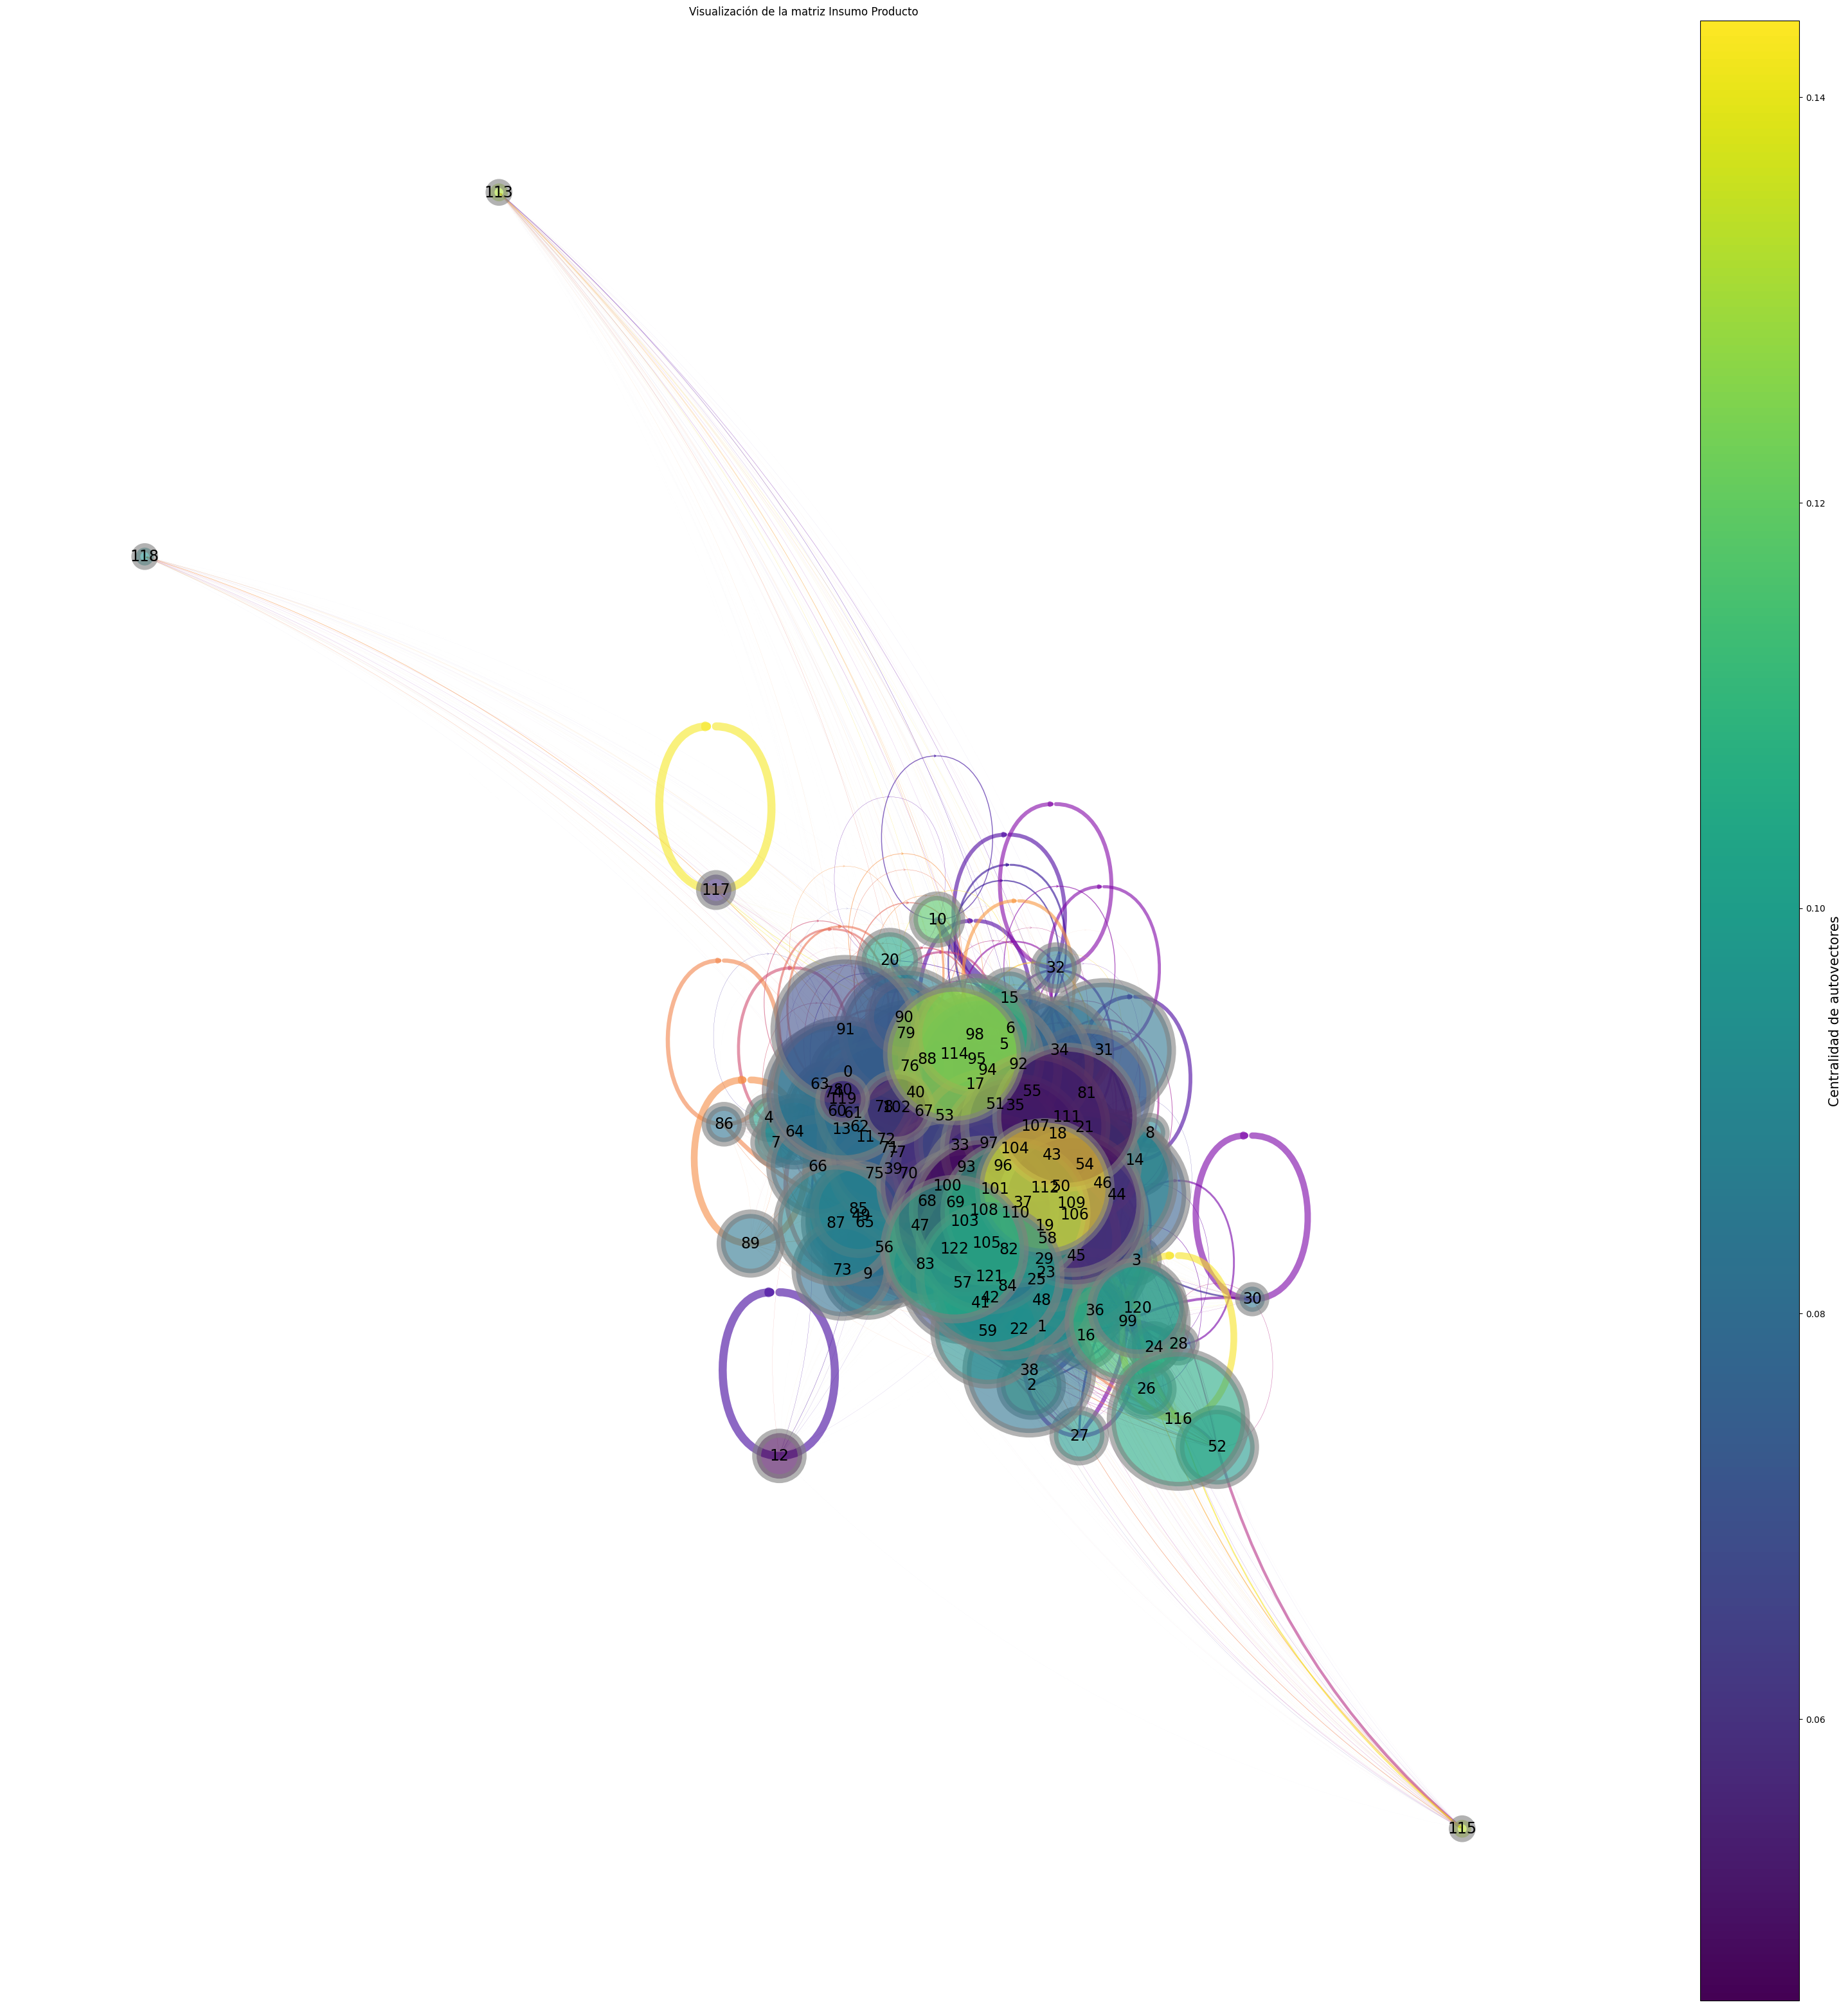

In [5]:
fig_gr_centralizado = grafo.verGrafoCentralizado(mip.to_numpy())

Intentemos separar los sectores para poder tener una mirada amplia.

In [6]:
# fig_gr_abierto = grafo.verGrafoAbierto(mip)

In [7]:
# fig_gr_abierto.savefig("../resources/grafo_abierto.png")

## Distribución de grado

Veremos cómo se distribuye el grado en la red. Para tener una noción de qué está pasando.

Media del Grado de salida:63.31707317073171
Desvio del Grado de salida:1961.1108467182228
Media del Grado de entrada:63.31707317073171
Desvio del Grado de entrada:162.3791394011501


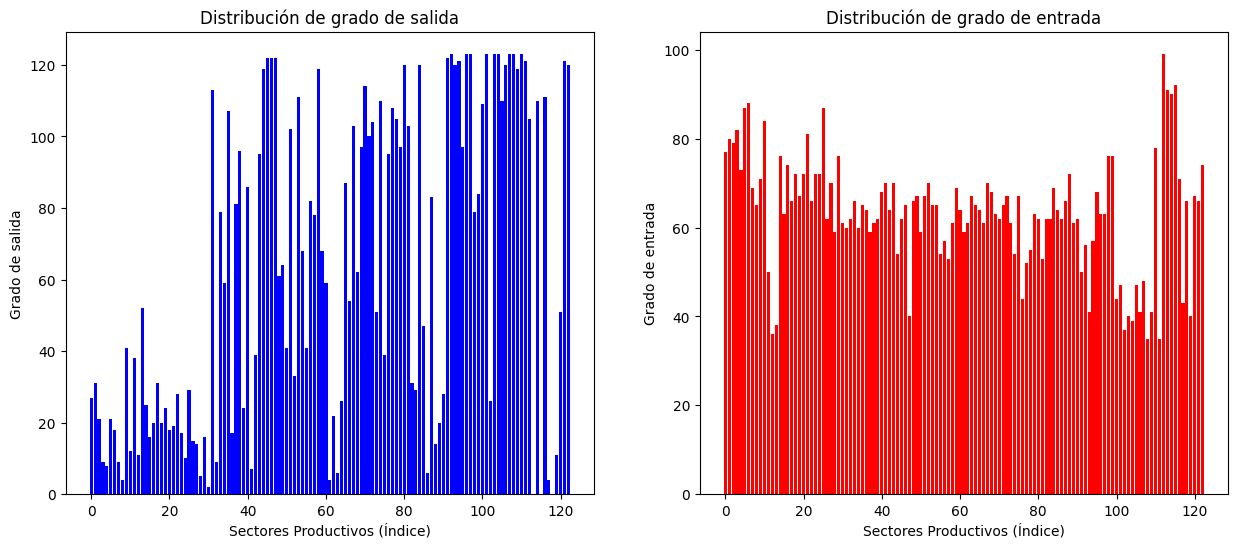

In [8]:
G = nx.DiGraph(mip)
fig_dist_grados = grafo.graficar_dist_grados(G, mip.columns)

## Centralidad de autovectores


> La centralidad de autovalores mide la influencia de un nodo sobre la red basado en la influencia de sus vecinos. Elegimos esta métrica para analizar el grafo pues los nodos que poseen un valor alto de esta medida de centralidad están conectados a otros nodos que a su vez son muy relevantes, en el sentido de la misma medida, o bien a muchos otros nodos, quizás menos relevantes. Por el contrario, los nodos conectados a otros nodos periféricos o poco relevantes, tendrán una baja centralidad de autovectores.

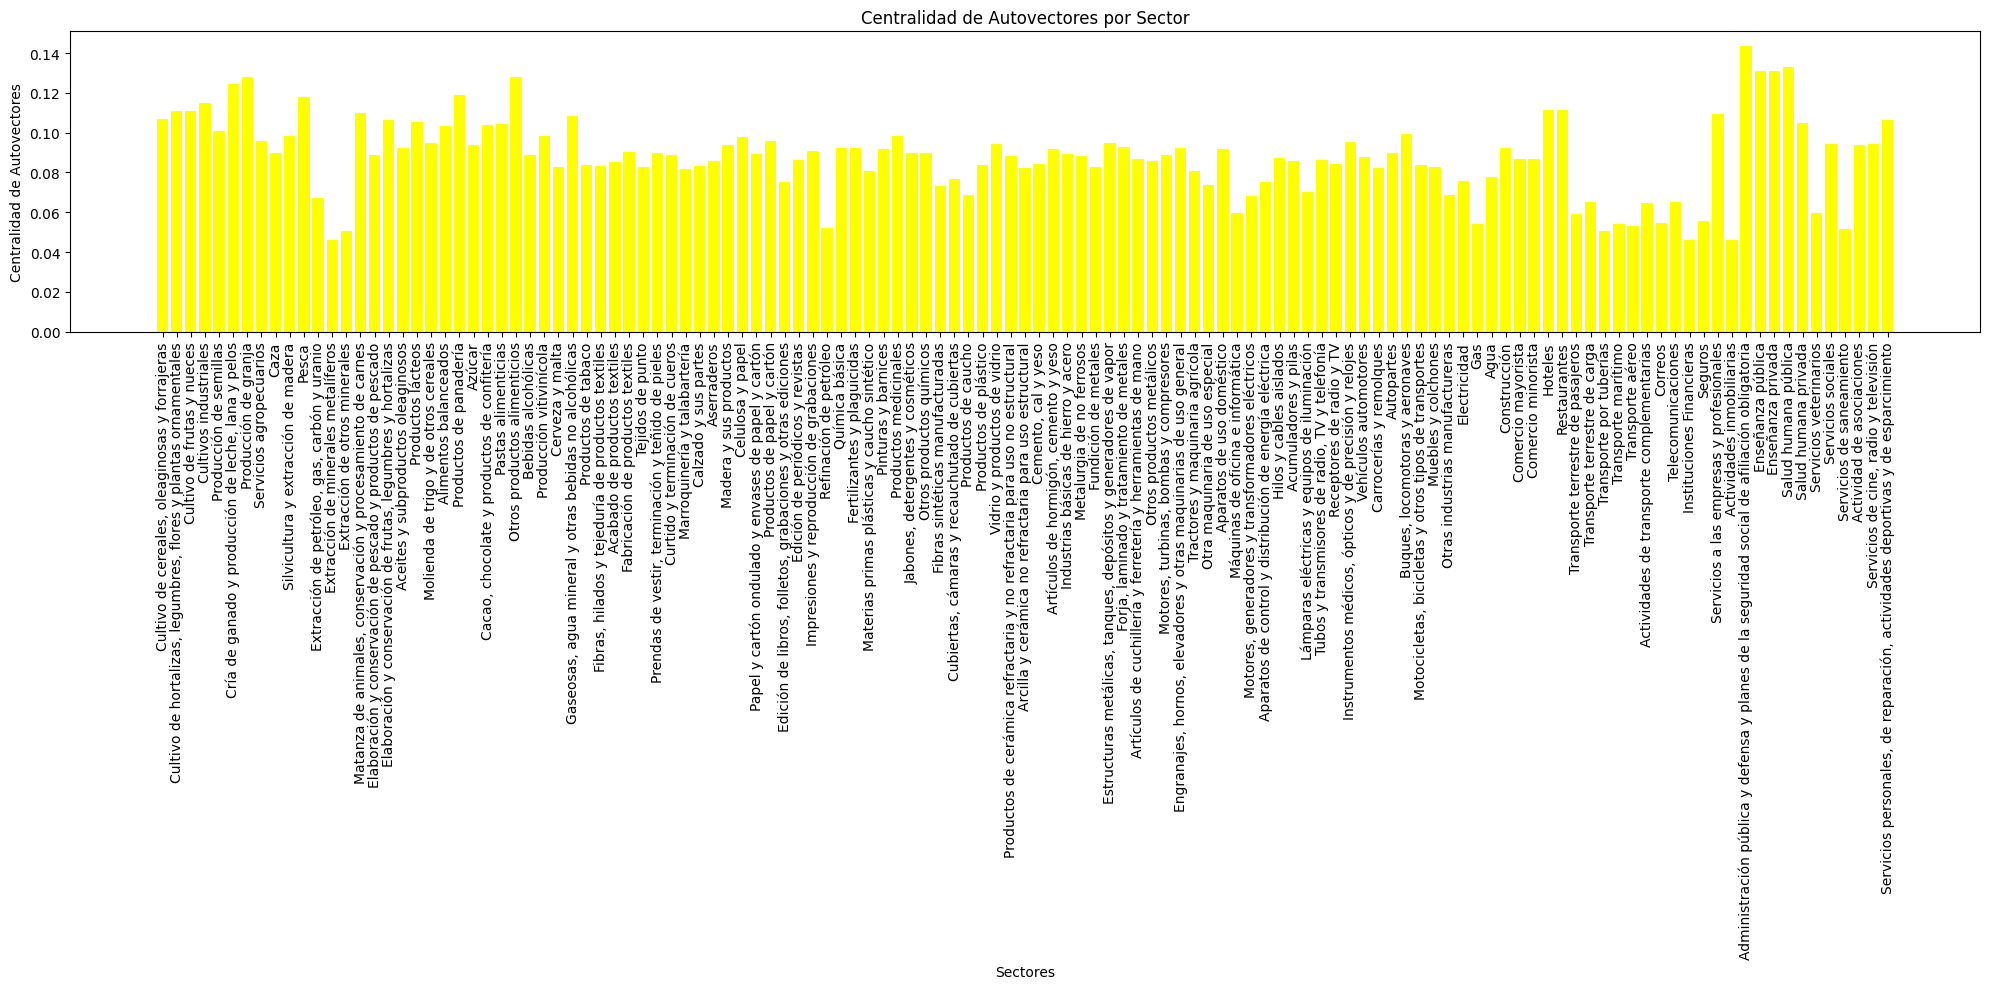

In [9]:
fig_dist_centralidad = grafo.graficar_dist_centralidad(G, mip.columns)

# Los experimentos

En esta etapa, haremos un análisis de la divergencia y convergencia de la inflación. Para 4 valores de alfa distintos, vamos a hacer un shock inflacionario en cada uno de los 123 sectores productivos y computaremos la media móvil de la inflación entre estas 123 simulaciones para cada alfa.
Además, mostraremos el grafo resultante luego de la evolución del sistema para dos sectores representativos de niveles de centralidad alto y bajo, respectivamente.

In [10]:
alfa0= pd.read_csv('../resources/alpha00.csv', index_col= 0)
alfa02= pd.read_csv('../resources/alpha02.csv', index_col= 0)
alfa03 = pd.read_csv('../resources/alpha03.csv', index_col= 0)
alfa04= pd.read_csv('../resources/alpha04.csv', index_col= 0)

## Experimentación con la `dinámica local`. 

Veamos qué sucede con un sector muy central y otro poco central.

In [11]:
def calcular_precios(mip, sector, dinamica, alpha=0.0):
    mip_grafo = grafo.armar_grafo(mip, precios_random=False)
    experimento = exp.Experimento(mip_grafo,
                                    dinamica=dinamica,
                                    calcular_inflacion=modelo.calcular_inflacion,
                                    duracion_periodo=20,
                                    alpha=alpha)
    experimento.shock(sector,20)
    experimento.step(600)
    precios_finales =[]
    for sector in mip_grafo.nodes():
        precio = mip_grafo.nodes()[sector]['precio']
        precios_finales.append(precio)
    
    precios_iniciales = [100 for _ in precios_finales]
    return precios_iniciales, precios_finales

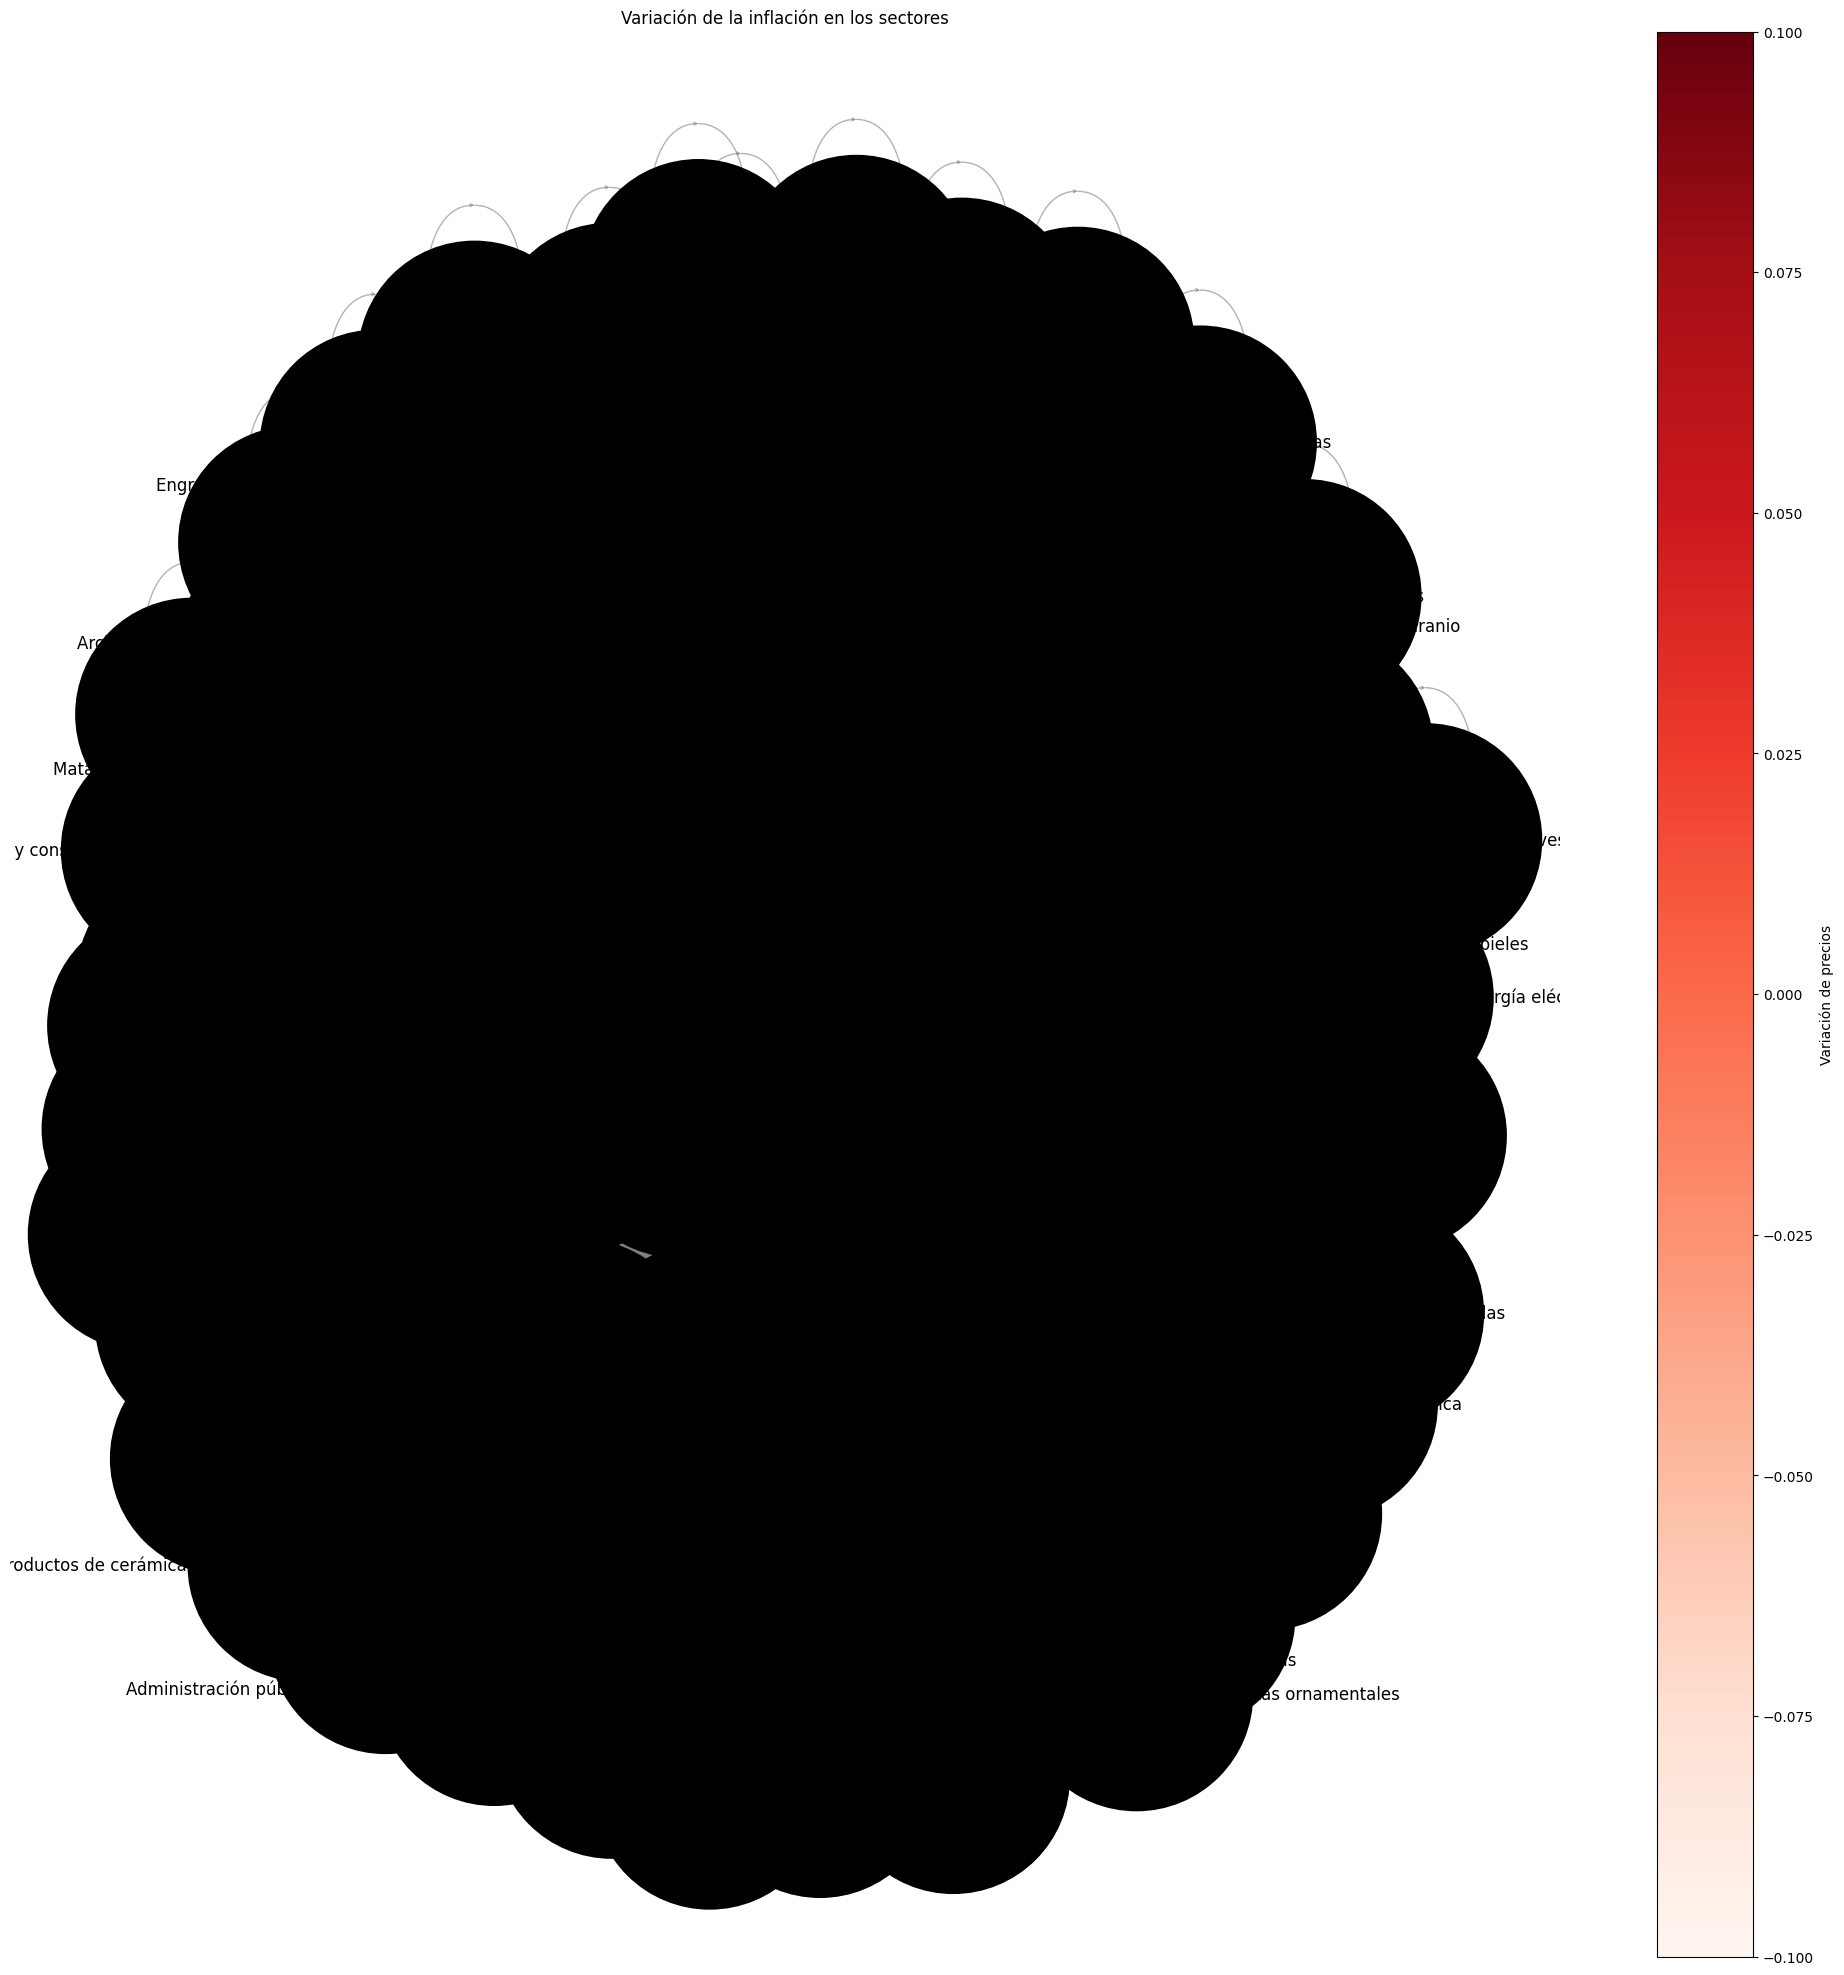

In [12]:
sector = 'Administración pública y defensa y planes de la seguridad social de afiliación obligatoria'
precios_iniciales, precios_finales = calcular_precios(mip, sector, modelo.dinamica_local)
fig_inf = grafo.verInflacion(mip, precios_finales, precios_iniciales)

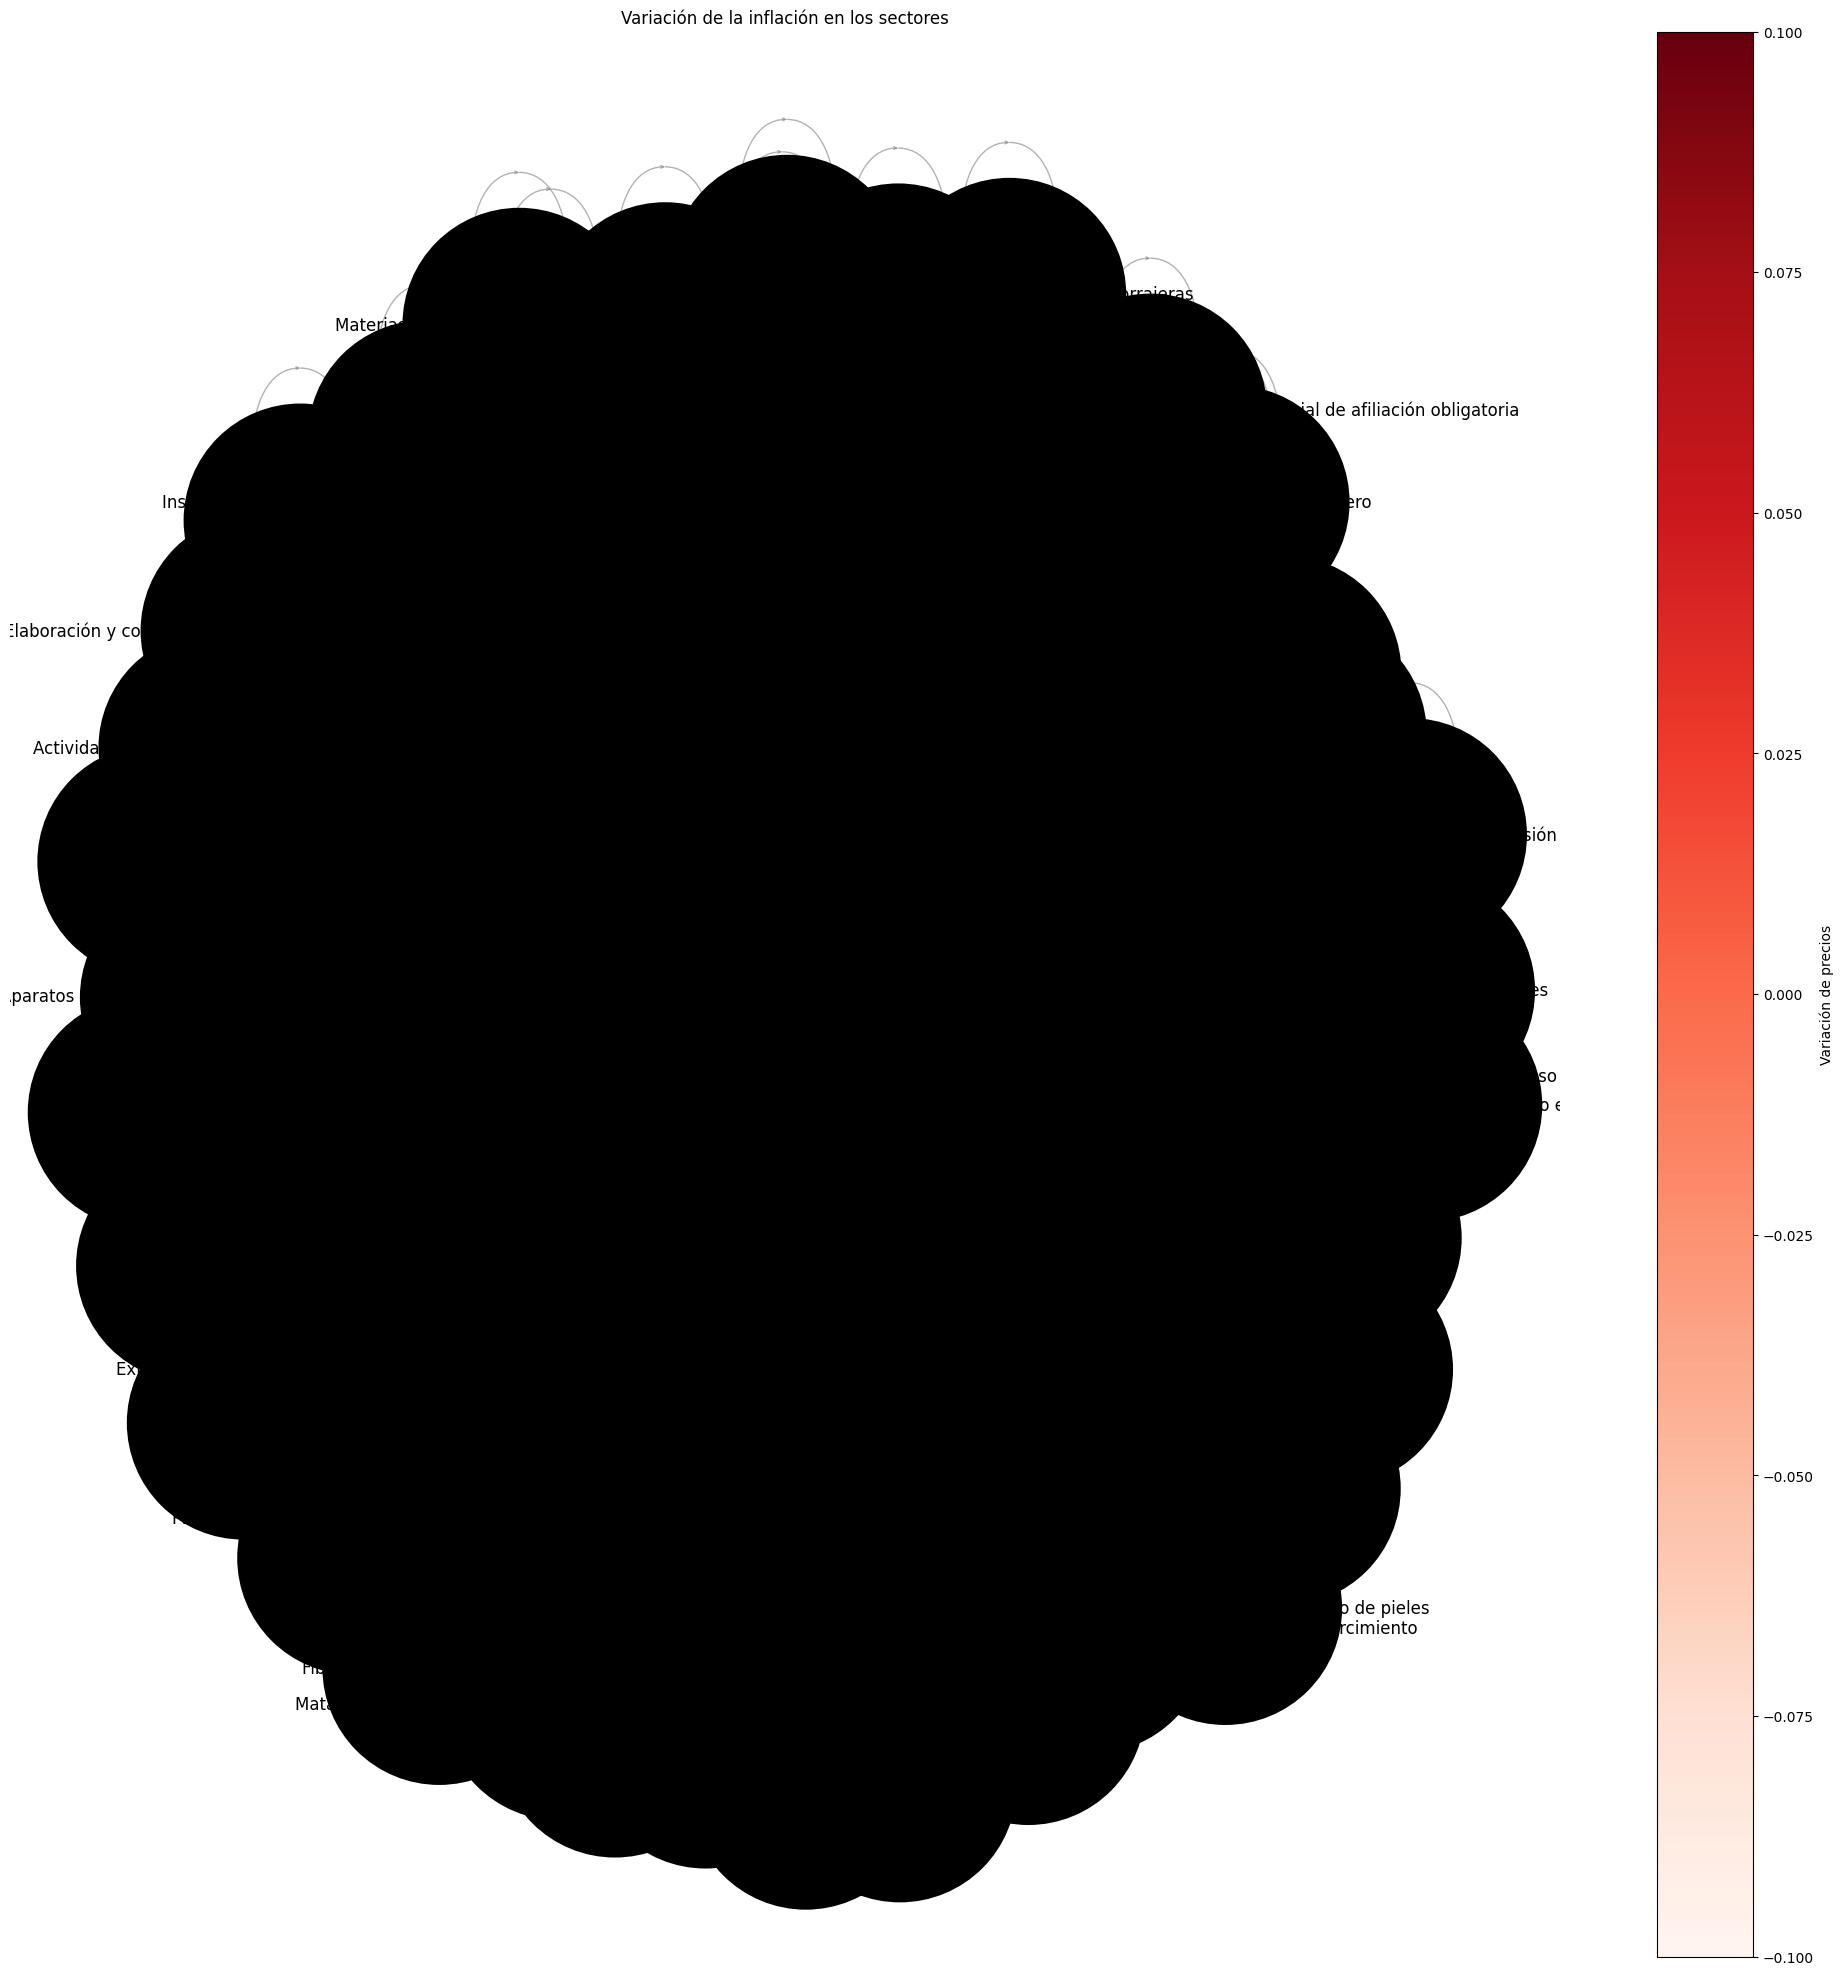

In [13]:
sector = 'Instituciones Financieras'
precios_iniciales, precios_finales = calcular_precios(mip, sector, modelo.dinamica_local)
fig_inf = grafo.verInflacion(mip, precios_finales, precios_iniciales)

In [14]:
def graficar_inflacion_para(mip_grafo, aumento, sectores=[]):
    inflaciones = []
    for sector in sectores:
        experimento = exp.Experimento(mip_grafo,
                                dinamica=modelo.dinamica_local,
                                calcular_inflacion=modelo.calcular_inflacion,
                                duracion_periodo=20)
        experimento.shock(sector,aumento)
        experimento.step(600)
        inflacion = experimento.metricas_evaluadas['inflacion']
        inflaciones.append(inflacion)  
    plot_inflaciones(inflaciones,aumento,3)

In [15]:
aumentos = [5, 20, 50]

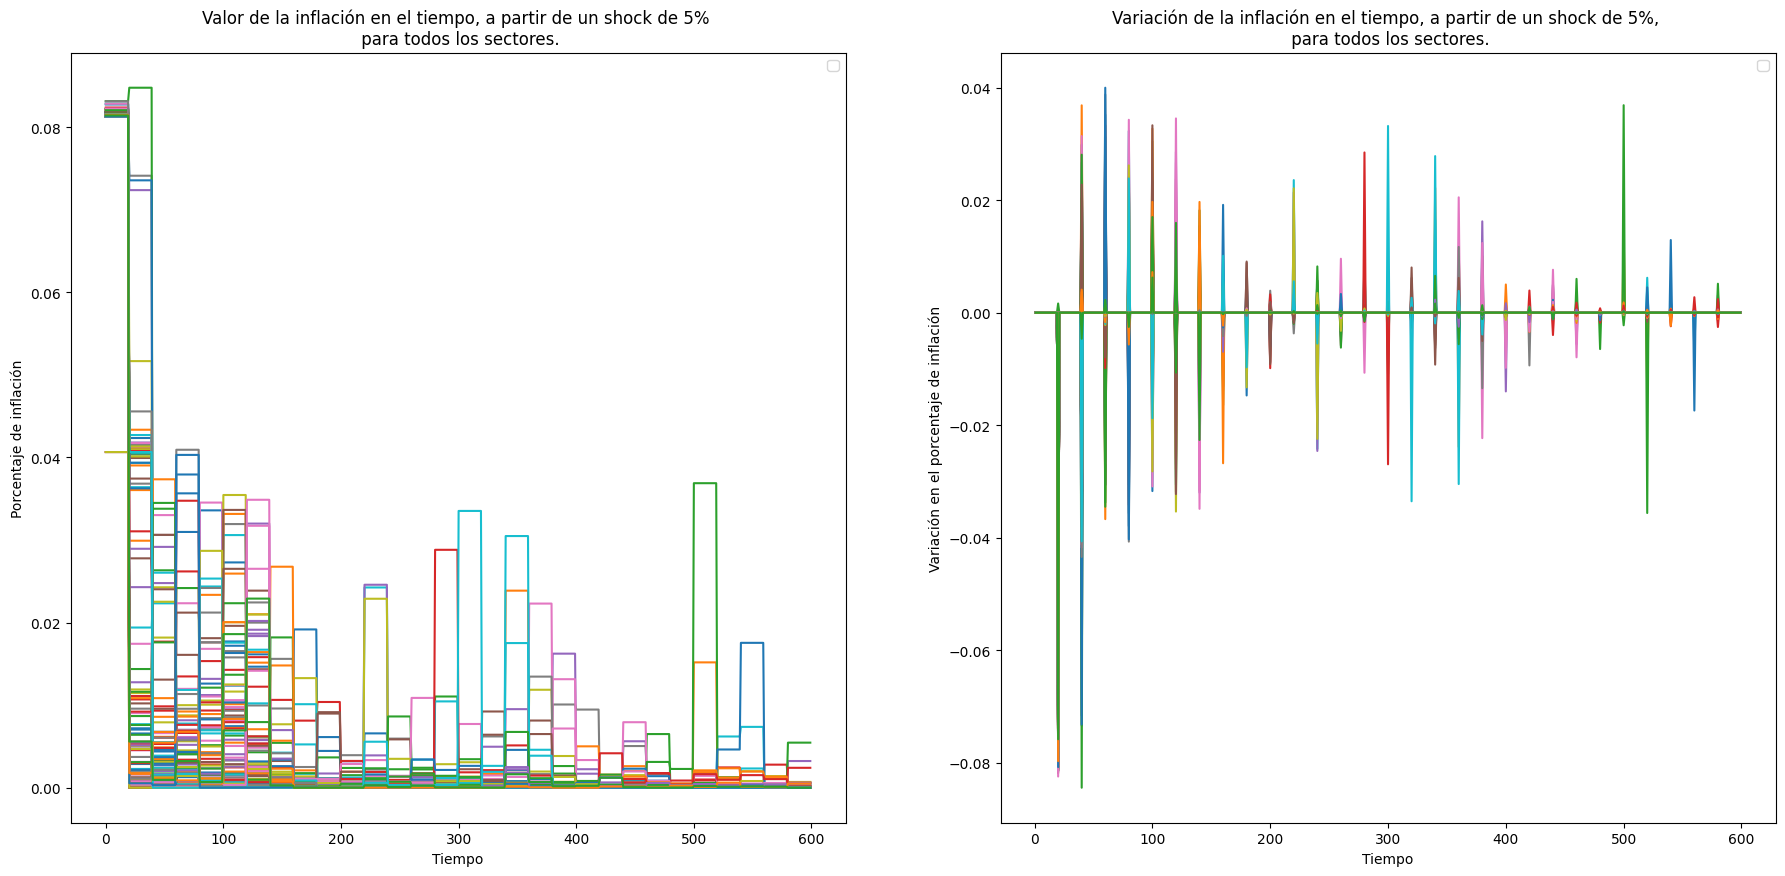

In [17]:
mip_grafo = grafo.armar_grafo(mip,precios_random=False)

graficar_inflacion_para(mip_grafo, aumentos[0], sectores = list(mip_grafo.nodes))

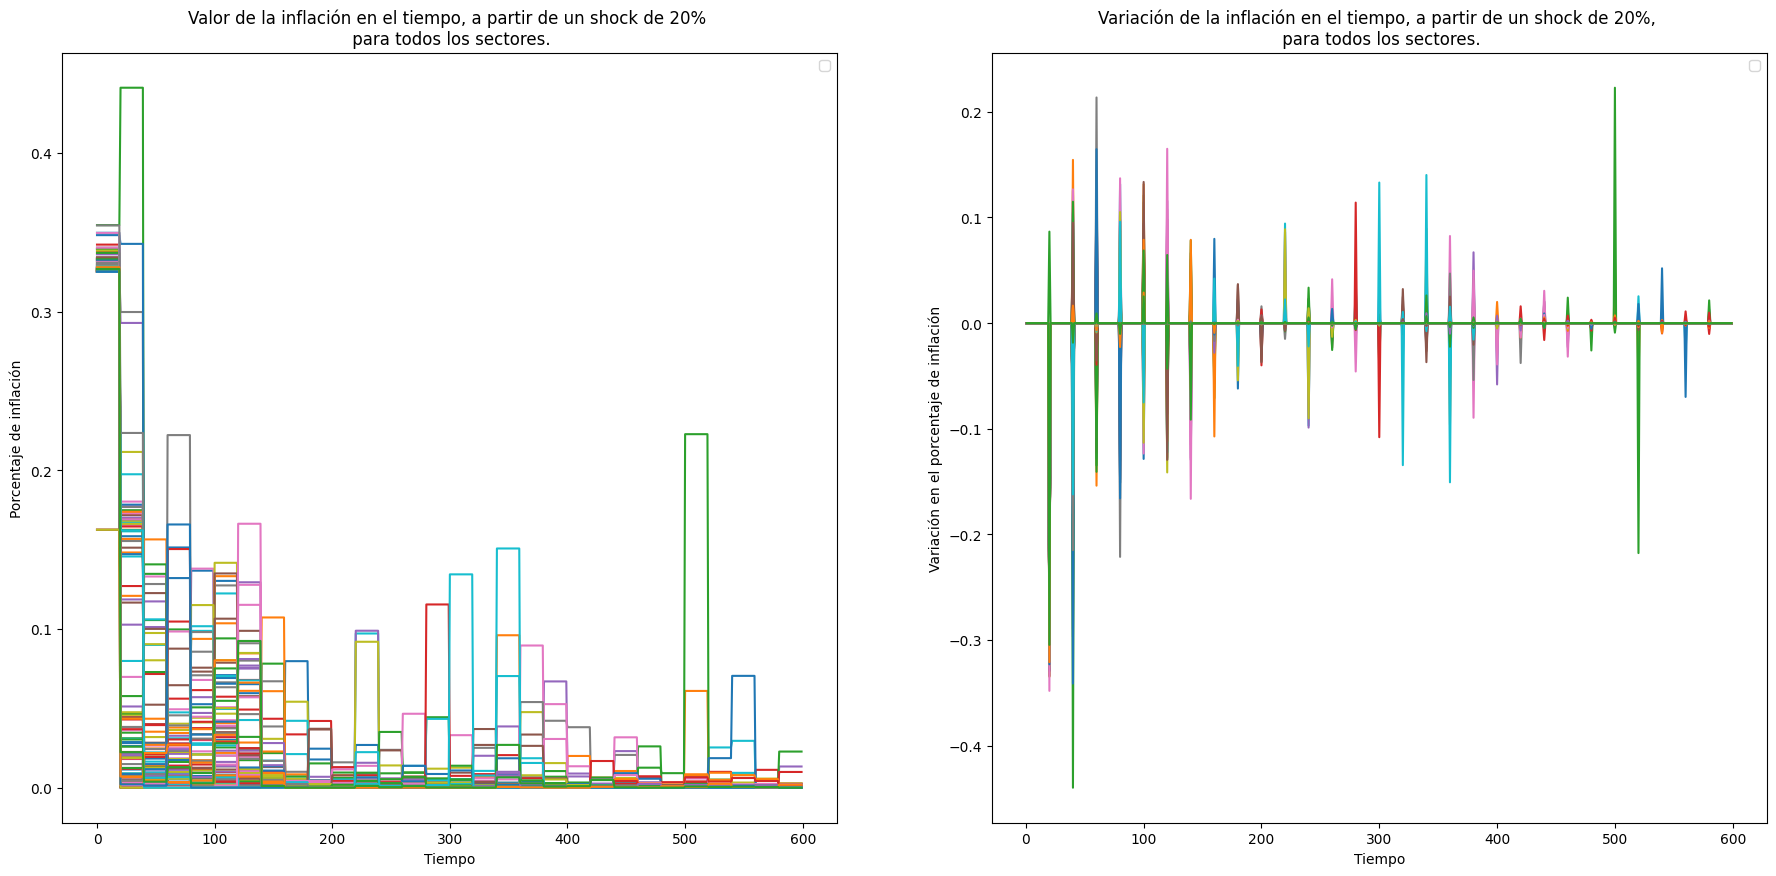

In [18]:
graficar_inflacion_para(mip_grafo, aumentos[1], sectores = list(mip_grafo.nodes))

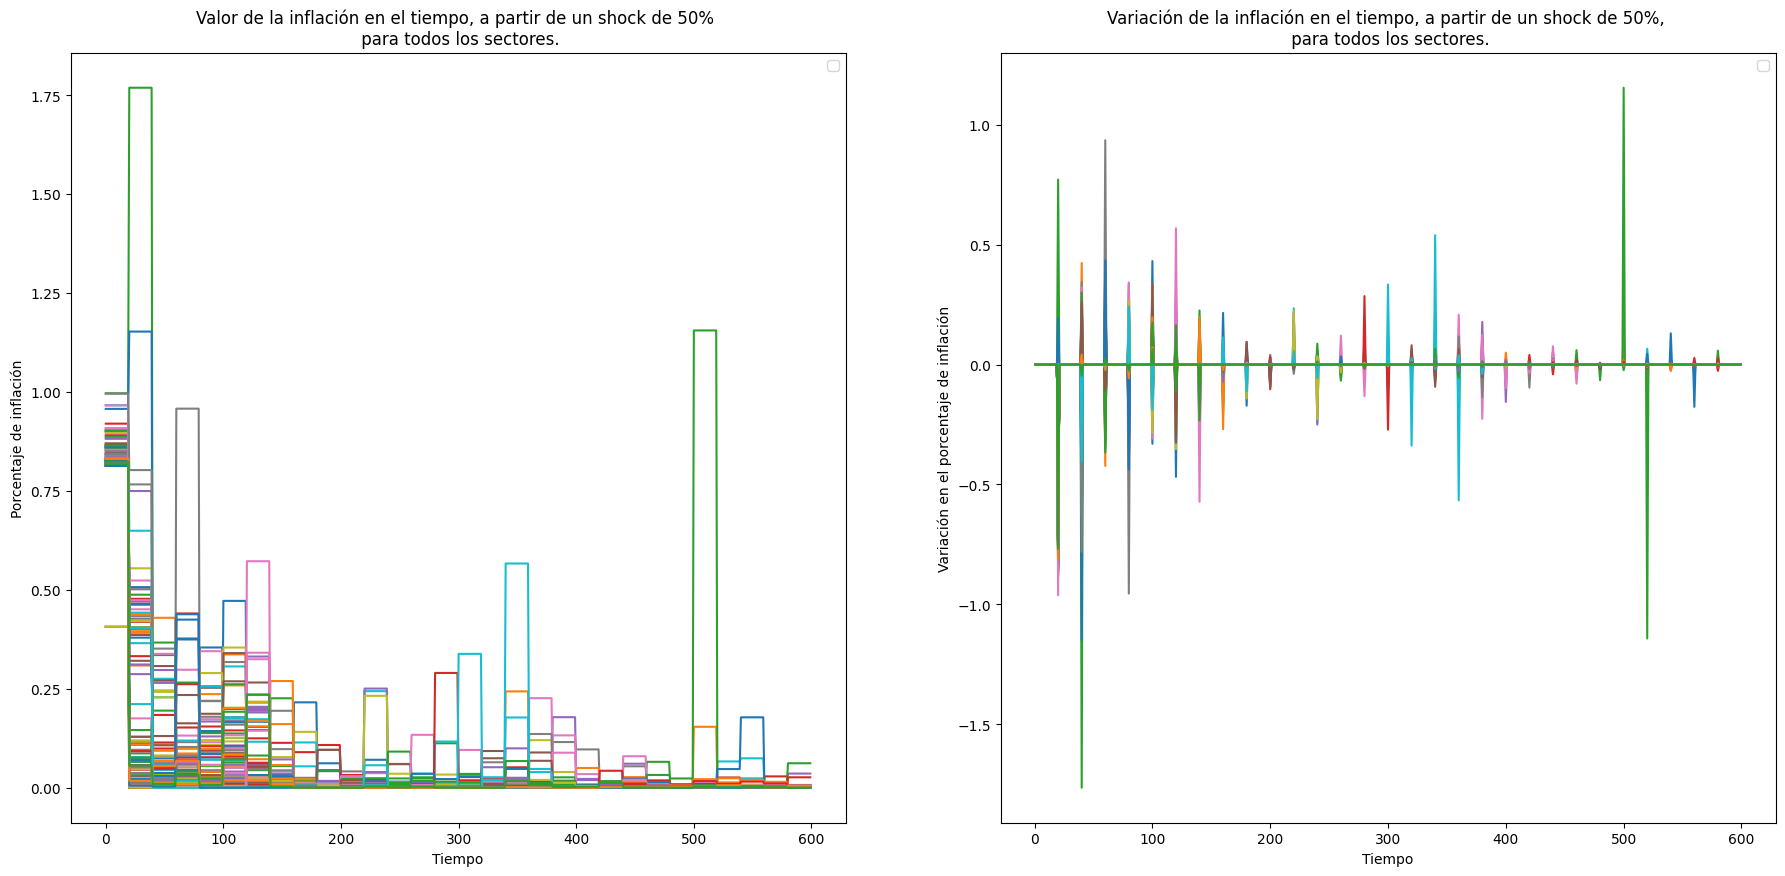

In [19]:
graficar_inflacion_para(mip_grafo, aumentos[2], sectores = list(mip_grafo.nodes))

## Experimentos con las dinámicas.

### alpha = 0 

In [20]:
# shock en dos sectores representativos

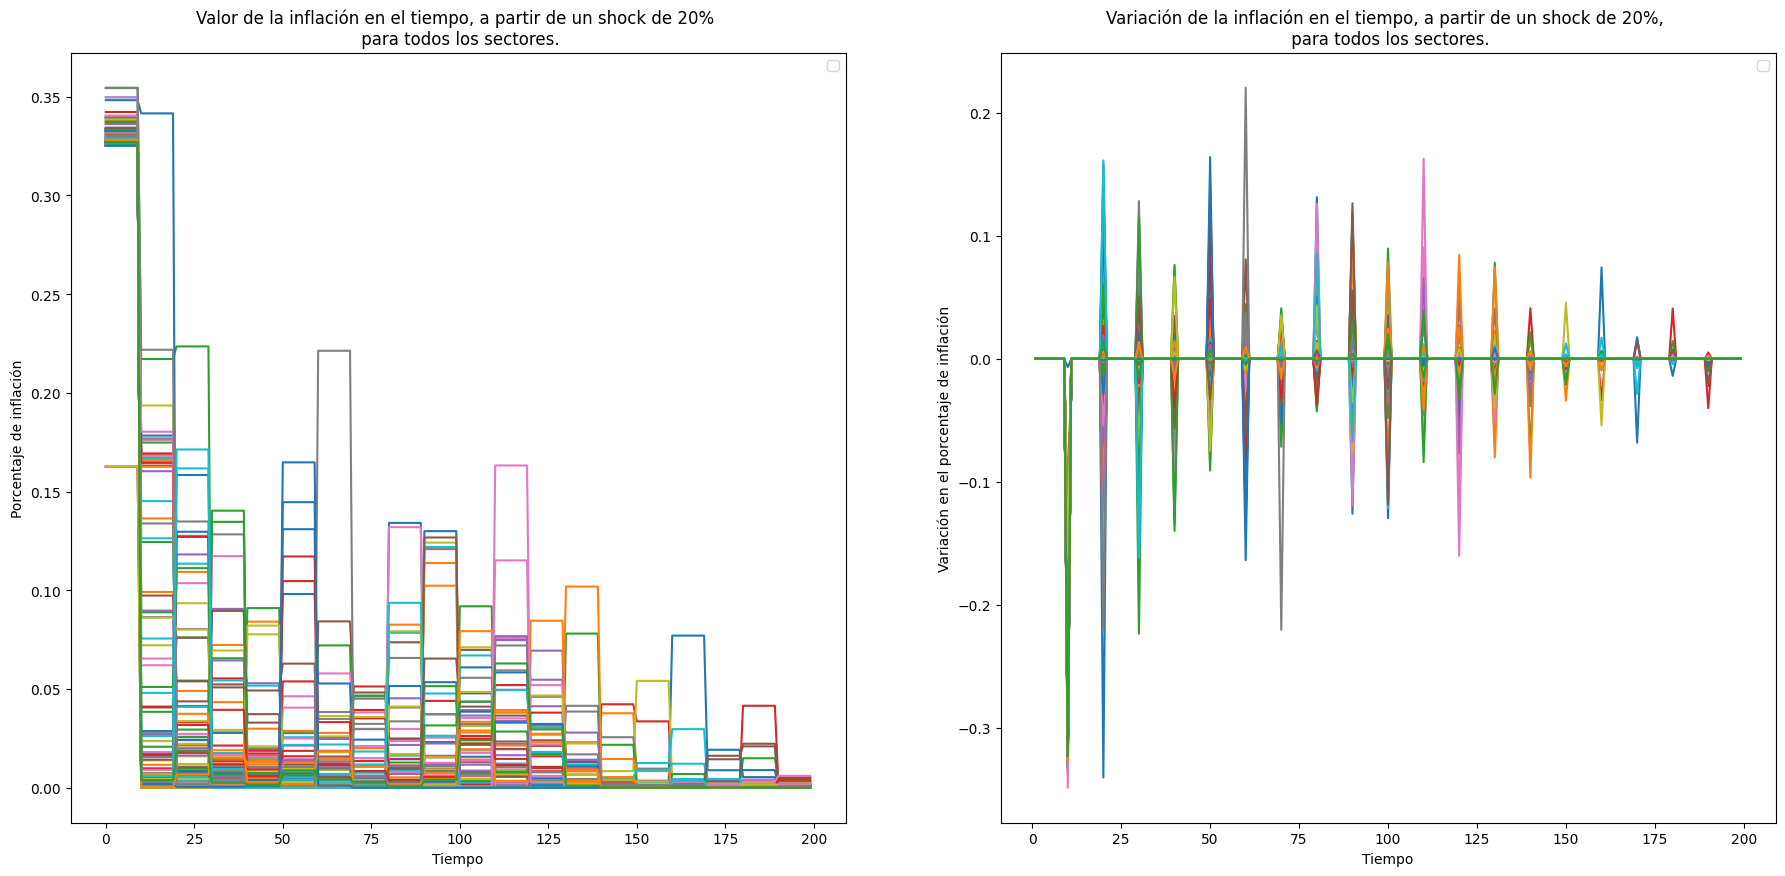

In [21]:
aumentos = [20]
alpha = 0

sectores = list(mip_grafo.nodes)
for j, aumento in enumerate(aumentos):       
    inflaciones = []
    for sector in sectores:
        experimento = exp.Experimento(mip_grafo,
                                dinamica=modelo.dinamica_mixta,
                                calcular_inflacion=modelo.calcular_inflacion,
                                alpha=alpha)
        experimento.shock(sector,aumento)
        experimento.step(200)
        inflacion = experimento.metricas_evaluadas['inflacion']
        inflaciones.append(inflacion)  
    plot_inflaciones(inflaciones, aumento)

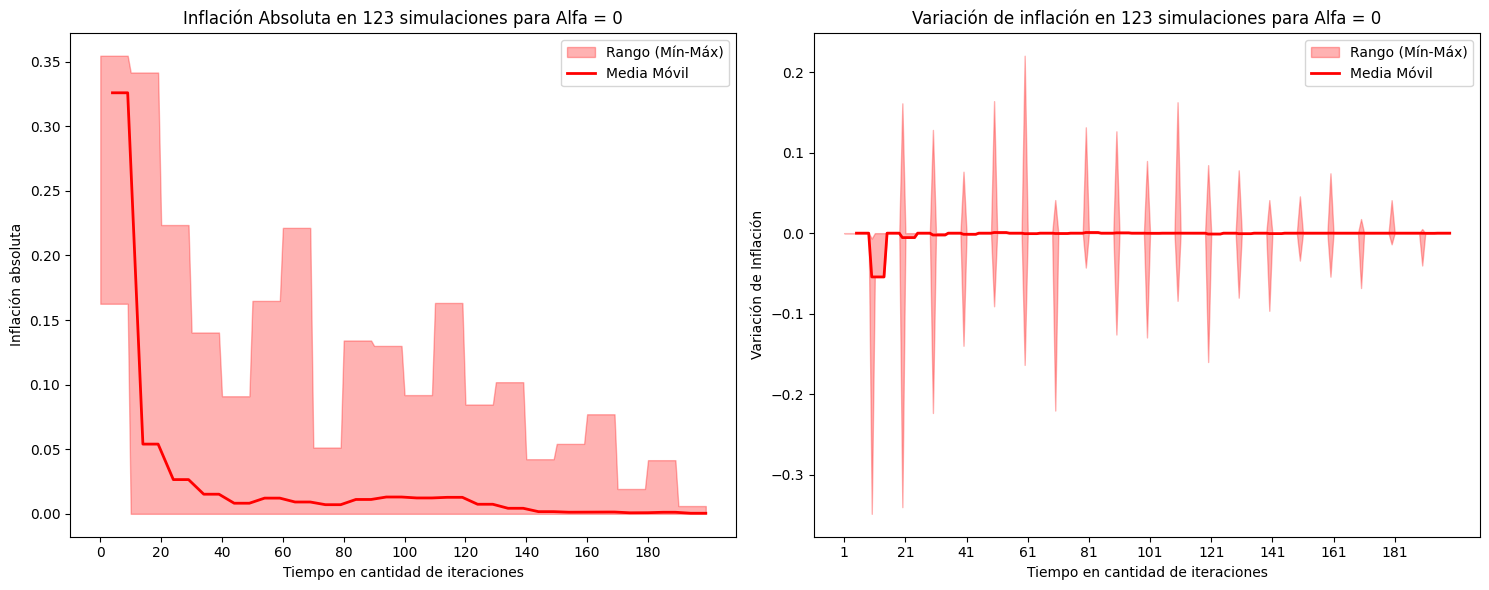

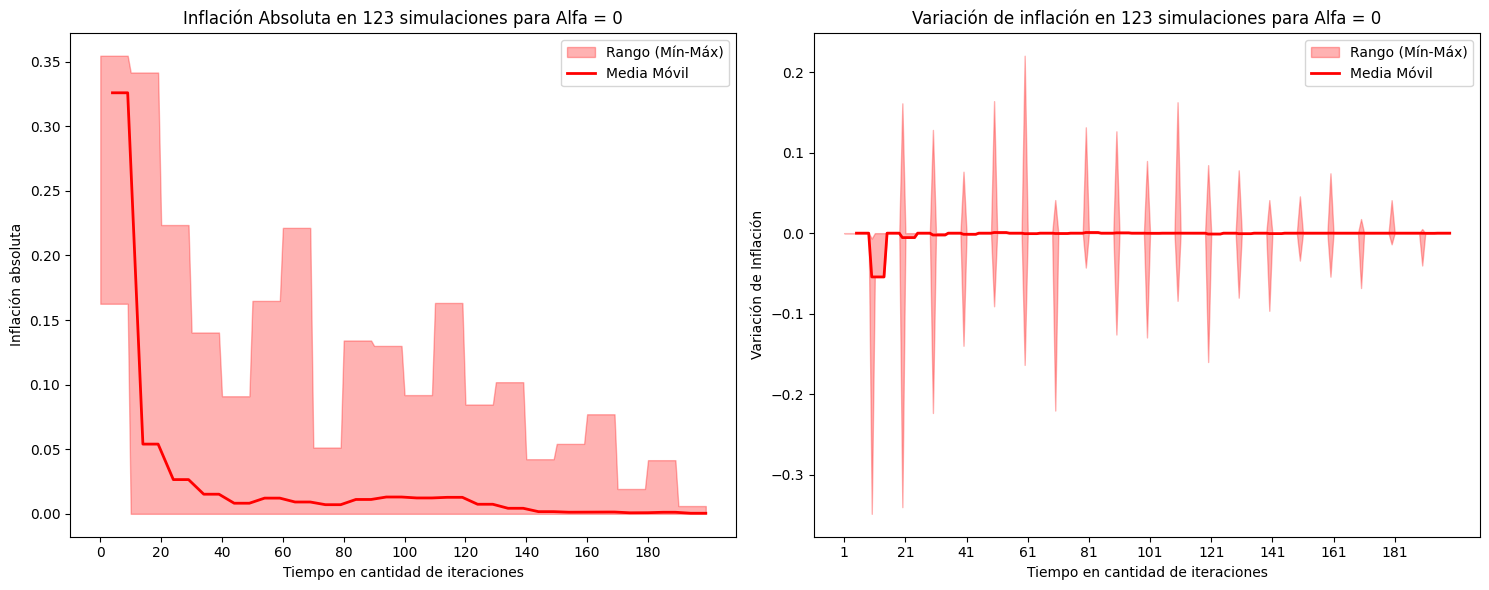

In [22]:
verEvolucion(alfa0, 'Alfa = 0')

### Alpha = 0.2

In [ ]:
alpha = 0.2

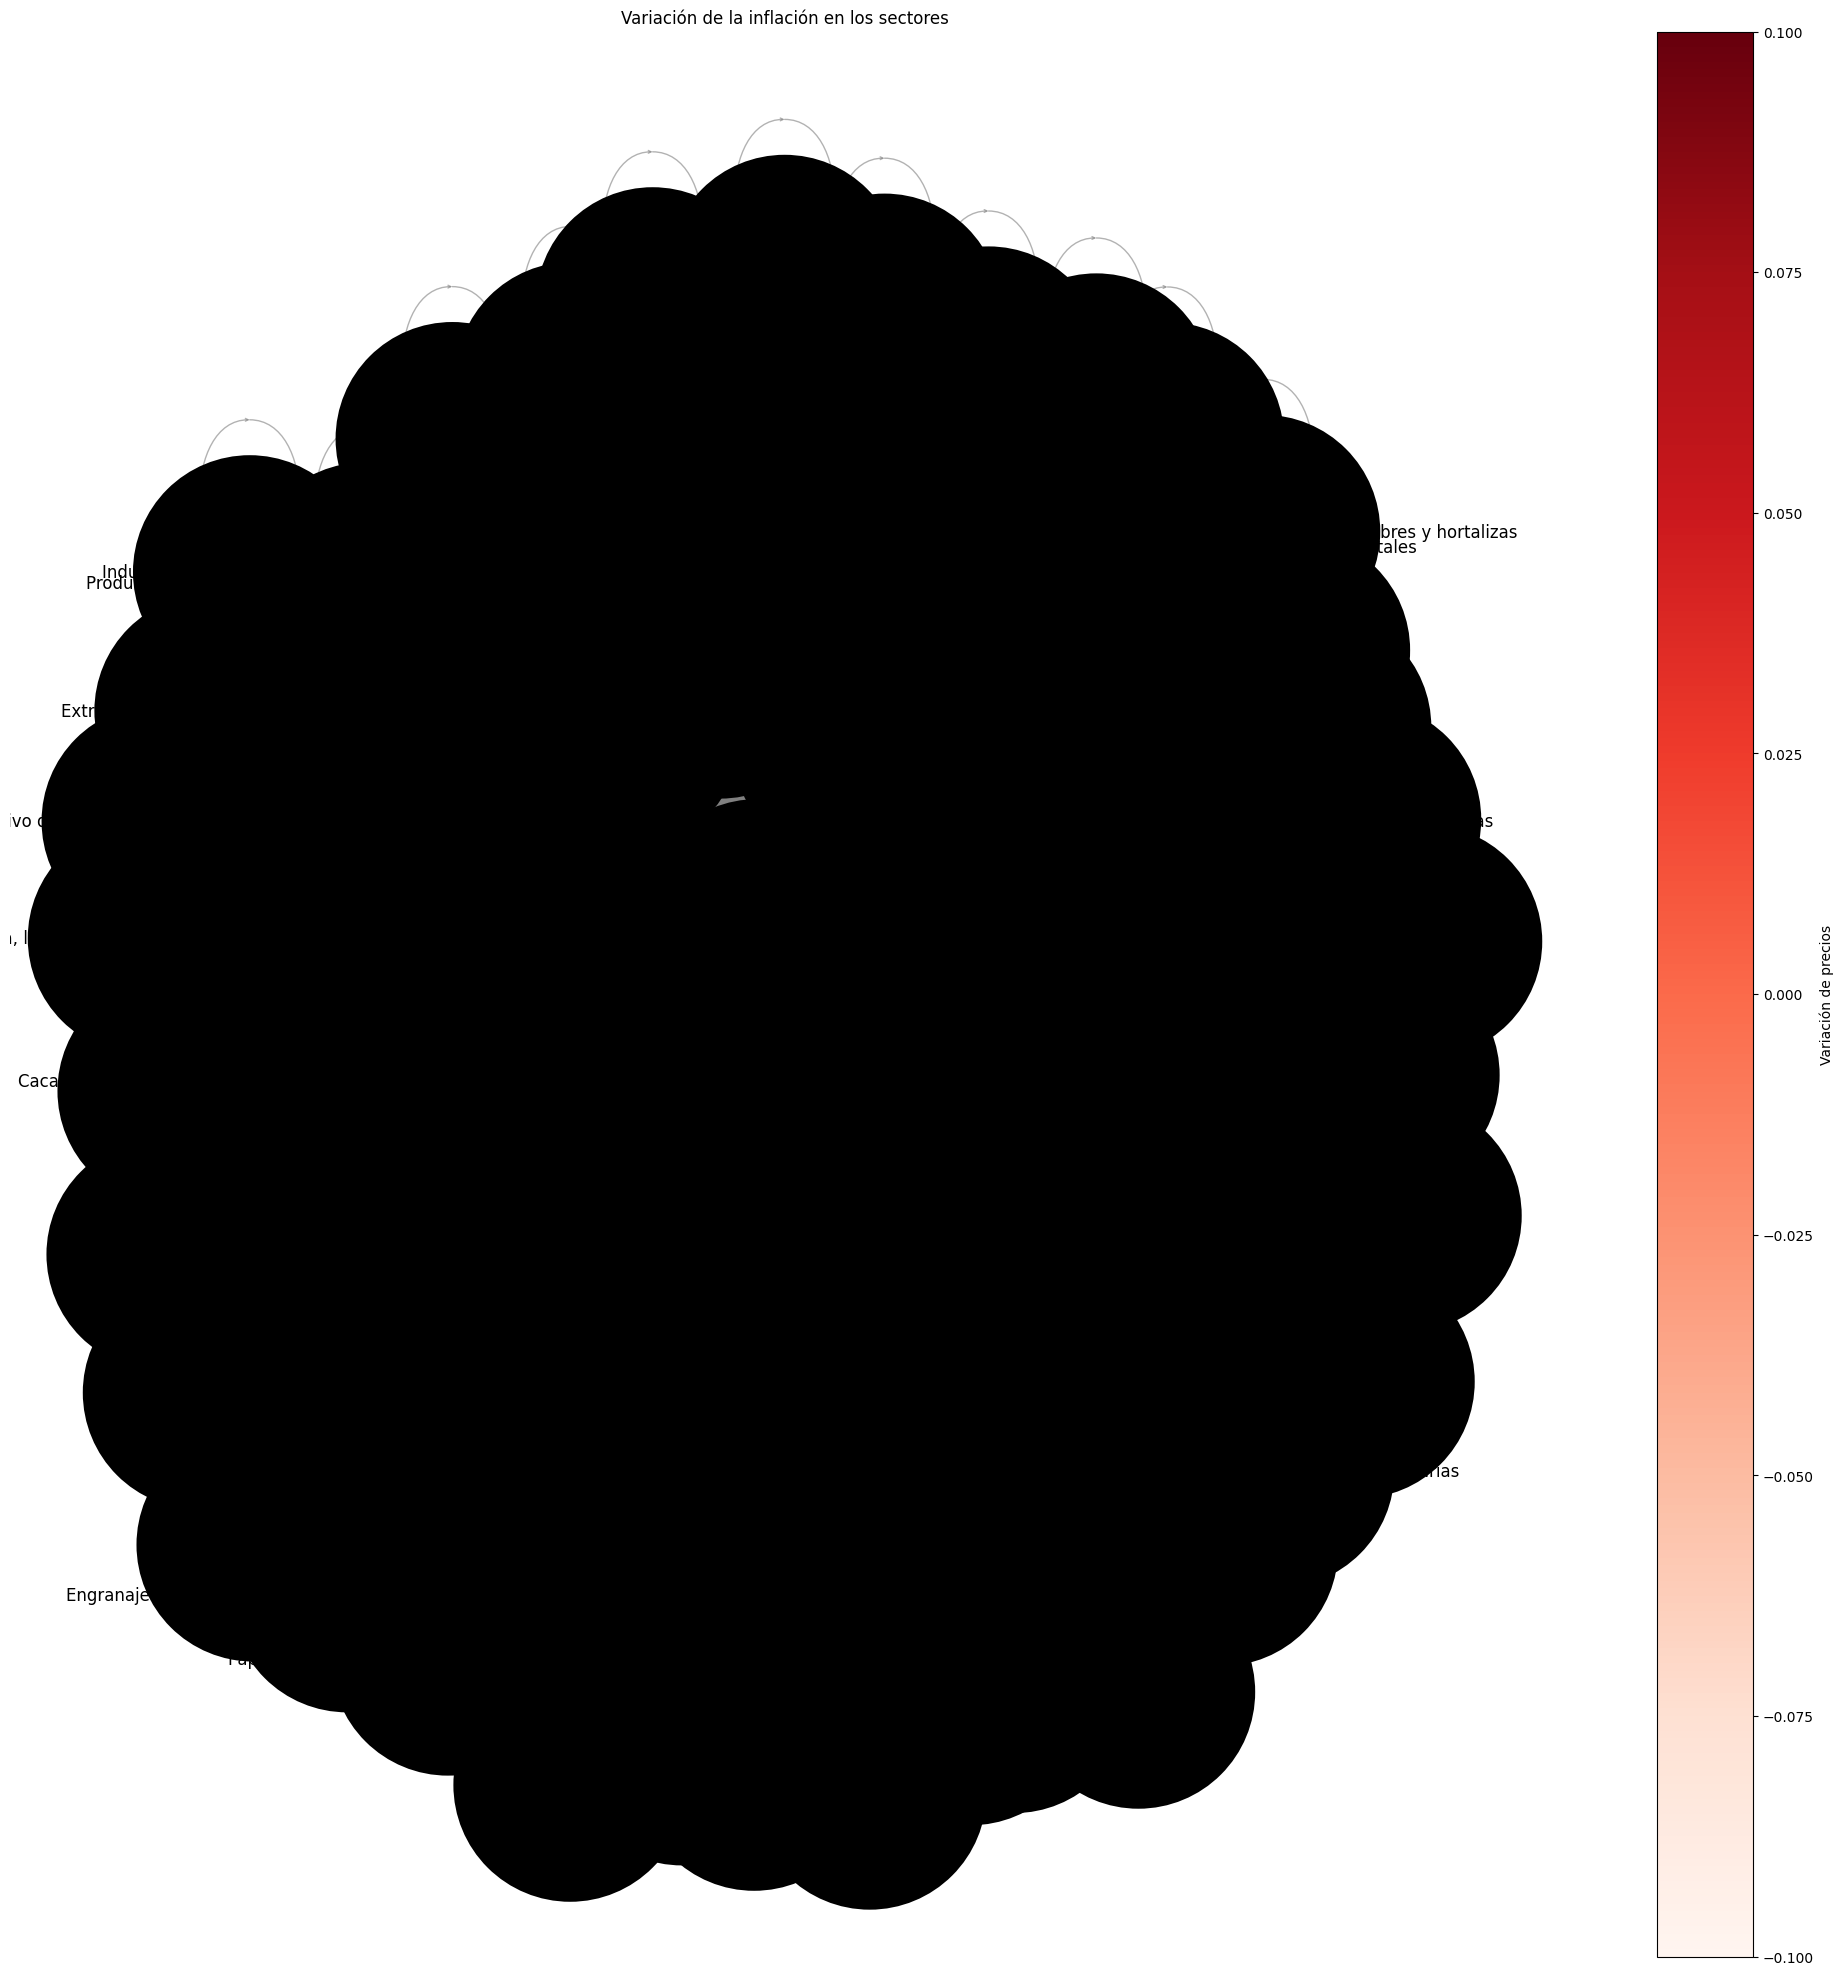

In [23]:
sector = 'Administración pública y defensa y planes de la seguridad social de afiliación obligatoria'

precios_iniciales, precios_finales = calcular_precios(mip, sector, modelo.dinamica_mixta, alpha=alpha)
fig_inf = grafo.verInflacion(mip, precios_finales, precios_iniciales)

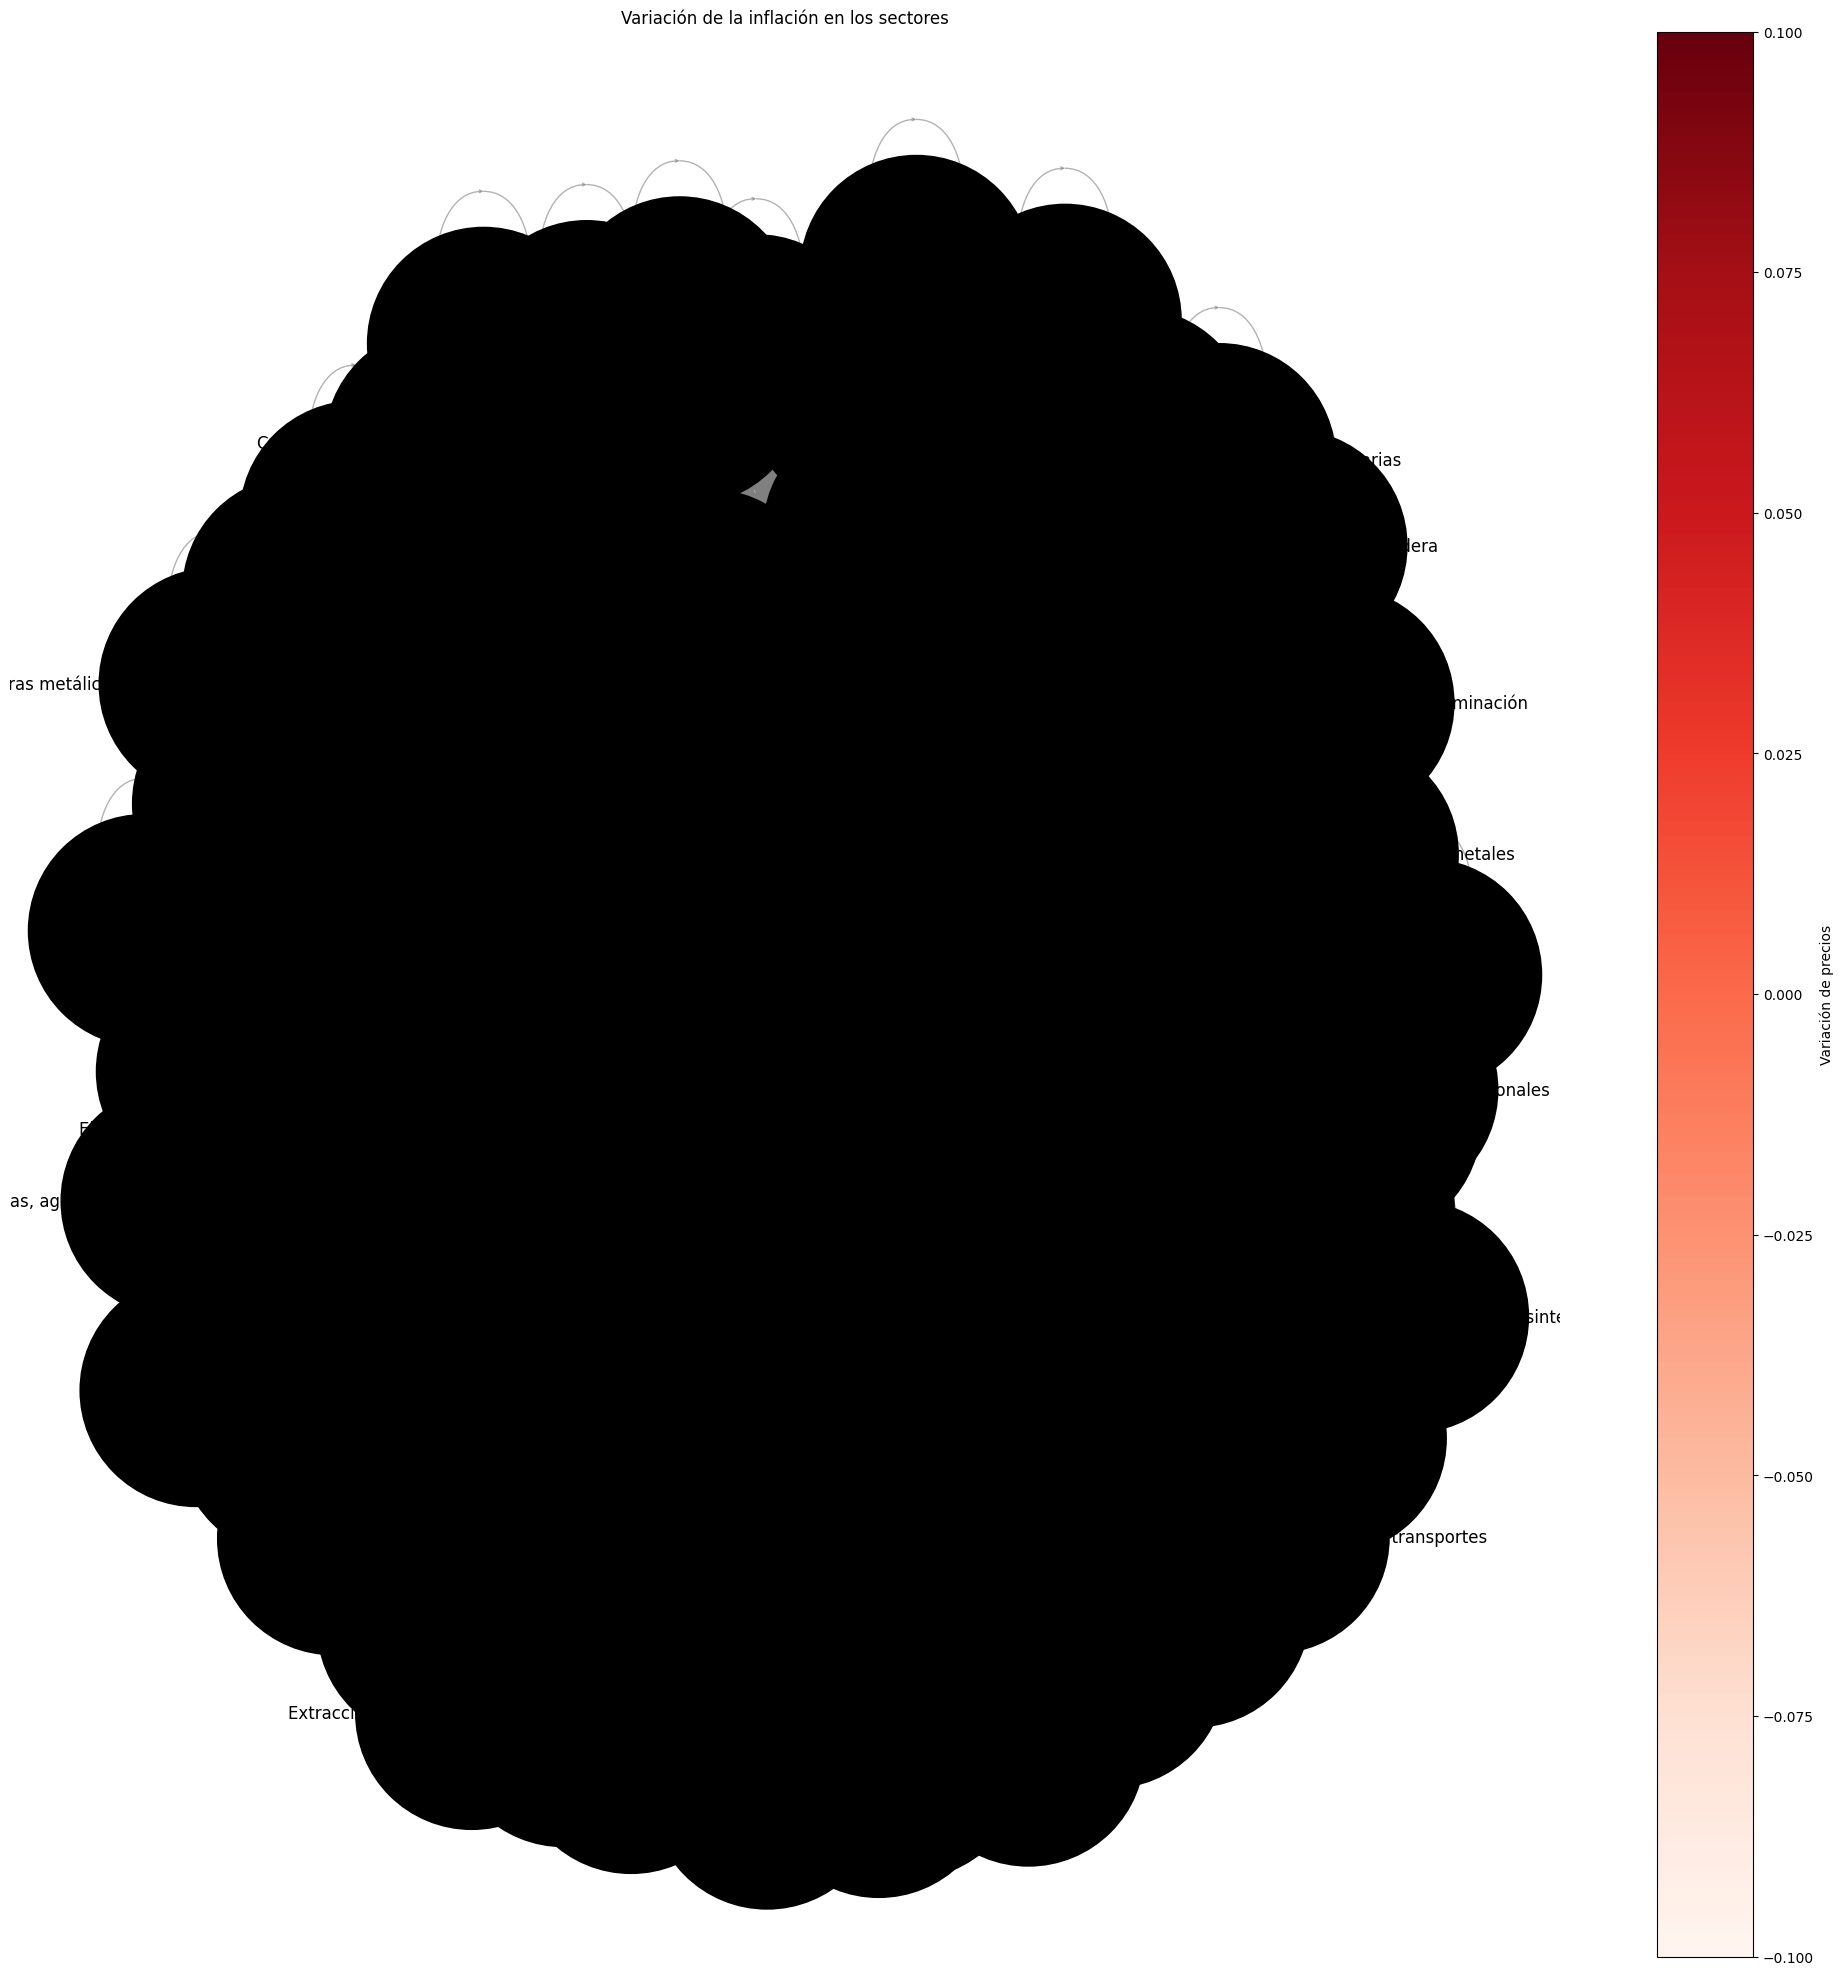

In [24]:
sector = 'Instituciones Financieras'
precios_iniciales, precios_finales = calcular_precios(mip, sector, modelo.dinamica_mixta, alpha=alpha)
fig_inf = grafo.verInflacion(mip, precios_finales, precios_iniciales)

In [ ]:
aumentos = [20]
umbral_visualizacion = [1000,2000,2000]

sectores = list(mip_grafo.nodes)
for j, aumento in enumerate(aumentos):       
    inflaciones = []
    for sector in sectores:
        experimento = exp.Experimento(mip_grafo,
                                dinamica=modelo.dinamica_mixta,
                                calcular_inflacion=modelo.calcular_inflacion,
                                alpha=alpha)
        experimento.shock(sector,aumento)
        experimento.step(500)
        inflacion = experimento.metricas_evaluadas['inflacion']
        inflaciones.append(inflacion)  

    plot_inflaciones(inflaciones,aumento,0.5)

In [ ]:
verEvolucion(alfa02, f'Alfa = {alpha}')

### Alpha 0.3

In [ ]:
alpha = 0.3

In [ ]:
sector = 'Administración pública y defensa y planes de la seguridad social de afiliación obligatoria'
precios_iniciales, precios_finales = calcular_precios(mip, sector, modelo.dinamica_mixta, alpha=alpha)
fig_inf = grafo.verInflacion(mip, precios_finales, precios_iniciales)

In [ ]:
sector = 'Instituciones Financieras'
precios_iniciales, precios_finales = calcular_precios(mip, sector, modelo.dinamica_mixta, alpha=alpha)
fig_inf = grafo.verInflacion(mip, precios_finales, precios_iniciales)

In [ ]:
aumento = 20
# umbral_visualizacion = [1000]

sectores = list(mip_grafo.nodes)
inflaciones = []
for sector in sectores:
    experimento = exp.Experimento(mip_grafo,
                            dinamica=modelo.dinamica_3,
                            calcular_inflacion=modelo.calcular_inflacion,
                            alpha=alpha)
    experimento.shock(sector,aumento)
    experimento.step(90)
    inflacion = experimento.metricas_evaluadas['inflacion']
    inflaciones.append(inflacion)  
plot_inflaciones(inflaciones, aumento,3)

In [ ]:
verEvolucion(alfa03, f'Alfa = {alpha}')

#### El mismo experimento pero con más pasos.

In [ ]:
aumento = 20

sectores = list(mip_grafo.nodes)
inflaciones = []
for sector in sectores:
    experimento = exp.Experimento(mip_grafo,
                            dinamica=modelo.dinamica_3,
                            calcular_inflacion=modelo.calcular_inflacion,
                            alpha=alpha)
    experimento.shock(sector,aumento)
    experimento.step(110)
    inflacion = experimento.metricas_evaluadas['inflacion']
    inflaciones.append(inflacion)  
plot_inflaciones(inflaciones,aumento,50)

### Alpha 0.4

In [ ]:
alpha = 0.4

In [ ]:
sector = 'Administración pública y defensa y planes de la seguridad social de afiliación obligatoria'
precios_iniciales, precios_finales = calcular_precios(mip, sector, modelo.dinamica_mixta, alpha=alpha)
fig_inf = grafo.verInflacion(mip, precios_finales, precios_iniciales)

In [ ]:
sector = ('Instituciones Financieras')
precios_iniciales, precios_finales = calcular_precios(mip, sector, modelo.dinamica_mixta, alpha=alpha)
fig_inf = grafo.verInflacion(mip, precios_finales, precios_iniciales)

In [ ]:
aumento = 20
# umbral_visualizacion = [1000]
sectores = list(mip_grafo.nodes)
inflaciones = []
for sector in sectores:
    experimento = exp.Experimento(mip_grafo,
                            dinamica=modelo.dinamica_mixta,
                            calcular_inflacion=modelo.calcular_inflacion,
                            alpha=alpha)
    experimento.shock(sector,aumento)
    experimento.step(100)
    inflacion = experimento.metricas_evaluadas['inflacion']
    inflaciones.append(inflacion)  
plot_inflaciones(inflaciones, aumento,3000)

In [ ]:
verEvolucion(alfa04, f'Alfa = {alpha}')

# Conclusiones

## Julio Olivera

> **Inflación estructural**: La inflación estructural se refiere a un tipo de inflación causada por desajustes sectoriales que afectan a productos específicos, lo que resulta en aumentos de precios individuales que luego se generalizan. Estos desajustes pueden ser el resultado de la rigidez de la estructura productiva y la imperfección de los mercados, y son ajenos a las decisiones de las autoridades monetarias. La inflación estructural se origina en desequilibrios sectoriales que afectan a productos específicos y no en un desajuste global entre la oferta y la demanda monetaria.
 
*Olivera, J. H. G. (1965), "Inflación estructural y política financiera”.*

Podemos notar que este modelo apoya la noción de que la inflación tiene un origen estructural. El hecho de que exista un alfa tal que si el aumento local de precios en un sector productivo estuviese dado por alfa*inflación_global, podría ser interpretado como una descoordinación entre los agentes. Estos hitos en la red estarían dando lugar a una espiralización de la inflación del modelo, que podría ser interpretada como la generalización de aumentos de precios individuales.


## Sobre los experimentos y las preguntas respondidas


- ¿Cómo se propaga el aumento de precios a través de la red definida por la MIP?



La propagación de un shock en el sistema productivo varía dependiendo tanto del sector a cual se realiza el shock como del alpha del experimento. En nodos que estan fuertemente conectados con otros, que propagan más un aumento, los shocks tienen más impacto que en aquellos con grados o pesos menores en sus aristas.

- ¿Cómo impacta el aumento de precio en un producto/sector sobre otros productos/sectores? ¿Se mantiene en la misma cadena productiva? ¿Cómo influyen la dinámica de comportamiento de los agentes en la variación de la inflación global?

Si el alpha es 0 el shock a un sector sólo genera cambios de precios en las aristas alcanzables por ese nodo. Además, como todos los pesos en las aristas son menores a 1, existe un decaimiento en los aumentos que se van pasando de sector a sector. """"""Por eso, ese caso, sí se puede decir que el aumento de precio se mantiene en la misma cadena productiva.""""""""
Por otro lado, cuando el alpha aumenta y los agentes se ven cada vez más influenciados por la inflación global a la hora de aumentar sus precios, la respuesta ya no es tan clara. Para que un agente tome la decisión de aumentar su precio, le tiene que llegar un aumento, es decir, no tienen la capacidad de actualizarse si no les "avisan". Por eso, es técnicamente cierto que el aumento se propaga sólo en la cadena productiva del sector que es shockeado. Lo interesante del modelo es que, al no ser nosotros los que definimos esa cadena sino que generamos la topografía de la red a partir del MIP, estas cadenas productivas son muy complejas y logran capturar todas las dependendias que existen entre sectores. A partir de eso, cuando el alpha aumenta, sectores a los que le hubiese llegado un aumento casi residual en un primer momento, toman la decisión de aumentar sus precios viendo la variable macro y así comienzan a generar aumentos generalizados en toda la red, es decir, inflación.  

- ¿Cuál es la sensibilidad del sistema respecto a variaciones de precio en nodos específicos? ¿Cuáles son los nodos que propagan de mayor forma la variación de precios?

Los sectores 'Administración pública y defensa y planes de la seguridad social de afiliación obligatoria', 'Enseñanza Pública', 'Enseñanza privada' y 'Salud humana pública' son los más influyentes en la red según la centralidad de autovalores. 

## Próximos pasos

 

* El modelo en su estado actual calcula la inflación a partir de un IPC basado en una canasta básica sin ponderar. Como primer paso sería interesante agregar ponderaciones a los sectores para lograr un mejor modelo.

* La MIP también tiene la información de cuánto de lo producido por un sector se vende al consumidor final. Con eso se puede generar un nuevo agente que represente ese sector, el del consumo final, y que tenga ciertos sectores más prioritarios que otros a la hora de consumirlo. Con eso, se podría eliminar el supuesto de la Ley de Say, agregando el consumo a las dinámicas. Eso podría dar lugar a deflación.

* Clusterizar ciertos nodos del grado en rubros, y estudiar los shocks dentro de esos micro-sectores.

* A partir de identificar los nodos en los cuales el grafo es mas vunlerable a un shock (Un shock en ellos generan significativamente más inflación que en el resto), plantear una reestructuración del grafo para hacerlo mas estable y seguro, teniendo en cuenta las restricciones pertinentes para que el grafo resultante siga siendo un esquema productivo. 

* Si se logra eliminar la Ley de Say, sería interesante reemplazar los sectores por agentes individuales de aquel sector, para poder modelar dinámicas de competencia en los precios.


# Apéndices

## Código

- [Experimento](#Experimento)
- [Bla](#Bla)

### Experimento

In [25]:
exp.Experimento??

Init signature:
exp.Experimento(
    grafo,
    dinamica,
    duracion_periodo=10,
    metricas=None,
    calcular_inflacion=None,
    alpha=0.5,
)
Docstring:      <no docstring>
Source:        
class Experimento:
  def __init__(self, grafo, dinamica, duracion_periodo = 10, metricas=None, calcular_inflacion=None, alpha = 0.5): 
    """
    Inicializa una instancia de la clase Experimento.

    Parámetros
    ----------
    grafo : DiGraph
      Grafo que representa el MIP
    dinamica : Callable 
      Función con la siguiente signatura : (aumento, peso_arista, inflacion, alpha)
    duracion_periodo : int, opcional
        La duración de cada período en pasos para actualizar la inflacion, por defecto 10 pasos.
    metricas : Dict(string,Callable), opcional
        Diccionario de con metricas a computar sobre el grafo, ej, {"cantidad_nodos", lambda grafo: len(grafo)}
    calcular_inflacion : Callable, opcional
        Función para calcular la inflación en un período, recibe dos arrays d

### Dinámicas

In [26]:
modelo.dinamica_local??

Signature: modelo.dinamica_local(aumento, peso_arista, inflacion=0.0, alpha=1.0)
Docstring: <no docstring>
Source:   
def dinamica_1(aumento, peso_arista, inflacion=0.0, alpha=1.0):
    aumento_vecino = aumento * peso_arista
    return aumento_vecino
File:      c:\users\augus\dev\gh\akielbowicz\tp-msscae-2024\src\modelo.py
Type:      function

In [27]:
modelo.dinamica_global??

Signature: modelo.dinamica_global(aumento, peso_arista, inflacion, alpha=1.0)
Docstring: <no docstring>
Source:   
def dinamica_2(aumento, peso_arista, inflacion, alpha=1.0):
    aumento_vecino = inflacion
    return aumento_vecino
File:      c:\users\augus\dev\gh\akielbowicz\tp-msscae-2024\src\modelo.py
Type:      function

In [28]:
modelo.dinamica_mixta??

Signature: modelo.dinamica_mixta(aumento, peso_arista, inflacion, alpha)
Docstring: <no docstring>
Source:   
def dinamica_3(aumento, peso_arista, inflacion, alpha):
    aumento_vecino = (alpha * inflacion) + ((1 - alpha) * ((aumento) * peso_arista))
    return aumento_vecino
File:      c:\users\augus\dev\gh\akielbowicz\tp-msscae-2024\src\modelo.py
Type:      function